# 0. Import

In [ ]:
#그래프의 전체적인 설정을 하는 객체
import matplotlib as mpl
#그래프를 그리는 객체
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
#나눔고딕 글자체의 전체 경로 설정
fontpath = 'C:/Windows/Fonts/NanumGothic.ttf'
#글자체의 경로와 글자 크기 설정
font = fm.FontProperties(fname=fontpath, size=9)

#폰트 이름 설정
plt.rc('font', family='NanumGothic') 
#폰트 업데이트
mpl.font_manager._rebuild()

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

from scipy import stats
from tqdm import tqdm
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# 1. 데이터 불러오기

In [ ]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
age_gender_info = pd.read_csv('./data/age_gender_info.csv')
area_age_car = pd.read_csv('./data/area_age_car_info.csv', encoding='euc-kr')
submission = pd.read_csv('./data/sample_submission.csv')

In [ ]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


# 2. 데이터 오류수정

### 1. 전용면적별 세대수 합계와 총세대수가 일치하지 않는 경우

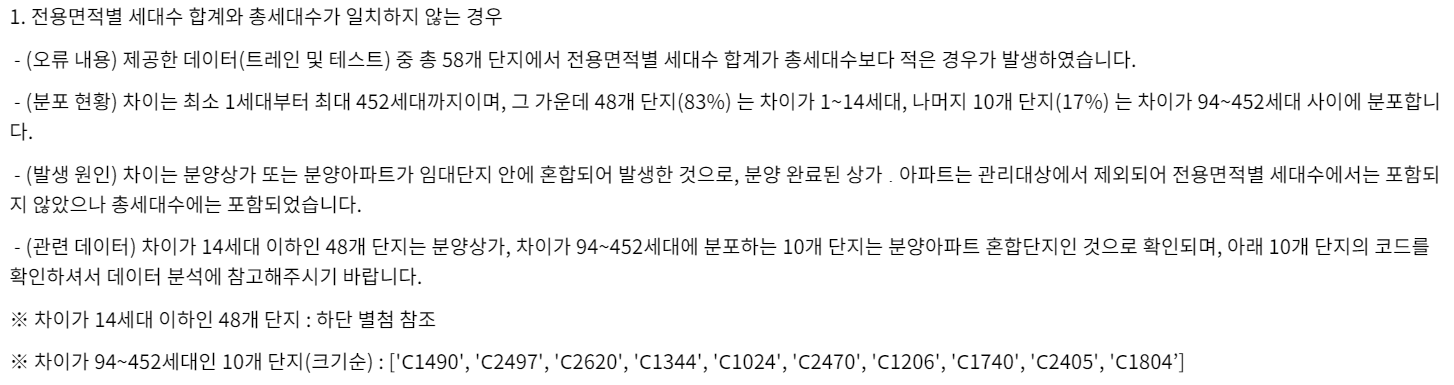

In [ ]:
train.head(5)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [ ]:
# 전용면적별 세대수
train_df1 = pd.DataFrame(train.groupby(['단지코드'])['전용면적별세대수'].sum()).reset_index()
test_df1 = pd.DataFrame(test.groupby(['단지코드'])['전용면적별세대수'].sum()).reset_index()

In [ ]:
train_df1.head()

,단지코드,전용면적별세대수
0,C1000,566
1,C1004,521
2,C1005,1144
3,C1013,1308
4,C1014,996


In [ ]:
test_df1.head()

,단지코드,전용면적별세대수
0,C1003,480
1,C1006,1505
2,C1016,643
3,C1019,321
4,C1030,70


In [ ]:
# 총세대수 중 중복 세대 제거
train_df2 = train[['단지코드','총세대수']].drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
test_df2 = test[['단지코드','총세대수']].drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

In [ ]:
train_df2.head()

,단지코드,총세대수
0,C2483,900
8,C2515,545
15,C1407,1216
26,C1945,755
32,C1470,696


In [ ]:
test_df2.head()

,단지코드,총세대수
0,C1072,754
8,C1128,1354
17,C1456,619
26,C1840,593
30,C1332,1297


In [ ]:
# 전용면적별 세대수 합계와 총세대수
train_df3 = pd.merge(train_df1, train_df2, how='inner')
test_df3 = pd.merge(test_df1, test_df2, how='inner')

In [ ]:
train_df3.head()

,단지코드,전용면적별세대수,총세대수
0,C1000,566,566
1,C1004,521,521
2,C1005,1144,1144
3,C1013,1308,1308
4,C1014,996,996


In [ ]:
test_df3.head()

,단지코드,전용면적별세대수,총세대수
0,C1003,480,480
1,C1006,1505,1505
2,C1016,643,643
3,C1019,321,321
4,C1030,70,75


In [ ]:
# 전용면적별 세대수 합계와 총세대수 차이 (총세대수 - 전용면적별세대수)
train_df3['diff'] = train_df3['총세대수'] - train_df3['전용면적별세대수']
test_df3['diff'] = test_df3['총세대수'] - test_df3['전용면적별세대수']

In [ ]:
train_df3.head()

,단지코드,전용면적별세대수,총세대수,diff
0,C1000,566,566,0
1,C1004,521,521,0
2,C1005,1144,1144,0
3,C1013,1308,1308,0
4,C1014,996,996,0


In [ ]:
test_df3.head()

,단지코드,전용면적별세대수,총세대수,diff
0,C1003,480,480,0
1,C1006,1505,1505,0
2,C1016,643,643,0
3,C1019,321,321,0
4,C1030,70,75,5


In [ ]:
print(train_df3[train_df3['diff'] != 0].size) # 총 160 단지에서 전용면적별 세대수 합계와 총세대수가 불일치
print(test_df3[test_df3['diff'] != 0].size)

160
72


In [ ]:
train_error1_complex1 = train_df3[(train_df3['diff']>=1) & (train_df3['diff']<=14)]['단지코드'].tolist()
test_error1_complex1 = test_df3[(test_df3['diff']>=1) & (test_df3['diff']<=14)]['단지코드'].tolist()

In [ ]:
print(len(train_error1_complex1), len(test_error1_complex1))
print(len(train_error1_complex1) + len(test_error1_complex1))

31 17
48


In [ ]:
train_error1_complex1[:5]

['C1068', 'C1156', 'C1218', 'C1312', 'C1424']

In [ ]:
test_error1_complex1[:5]

['C1030', 'C1038', 'C1229', 'C1266', 'C1267']

In [ ]:
train_error1_complex2 = train_df3[train_df3['diff']>=94]['단지코드'].tolist()
test_error1_complex2 = test_df3[test_df3['diff']>=94]['단지코드'].tolist()

In [ ]:
print(len(train_error1_complex2), len(test_error1_complex2))
print(len(train_error1_complex2) + len(test_error1_complex2))

9 1
10


In [ ]:
train_error1_complex2[:5]

['C1024', 'C1206', 'C1344', 'C1490', 'C1740']

In [ ]:
test_error1_complex2

['C2497']

In [ ]:
# 1번 오류를 수정
# 차이가 14세대 이하인 세대는 총세대수를 전용면적별세대수로 바꾸기

for i in range(len(train.index)):
    # n : 대체되는 값
    n = train_df3[train_df3['단지코드'] == train.loc[i, '단지코드']]['전용면적별세대수'].tolist()[0]
    train.loc[i, '총세대수'] = n

for i in range(len(test.index)):
    # n : 대체되는 값
    n = test_df3[test_df3['단지코드'] == test.loc[i, '단지코드']]['전용면적별세대수'].tolist()[0]
    test.loc[i, '총세대수'] = n

In [ ]:
# 차이가 94세대 이상인 세대는 제거
train = train.set_index(['단지코드'])
train = train.drop(train_error1_complex2)
train = train.reset_index()

In [ ]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


### 2. 동일한 단지에 단지코드가 2개로 부여된 경우

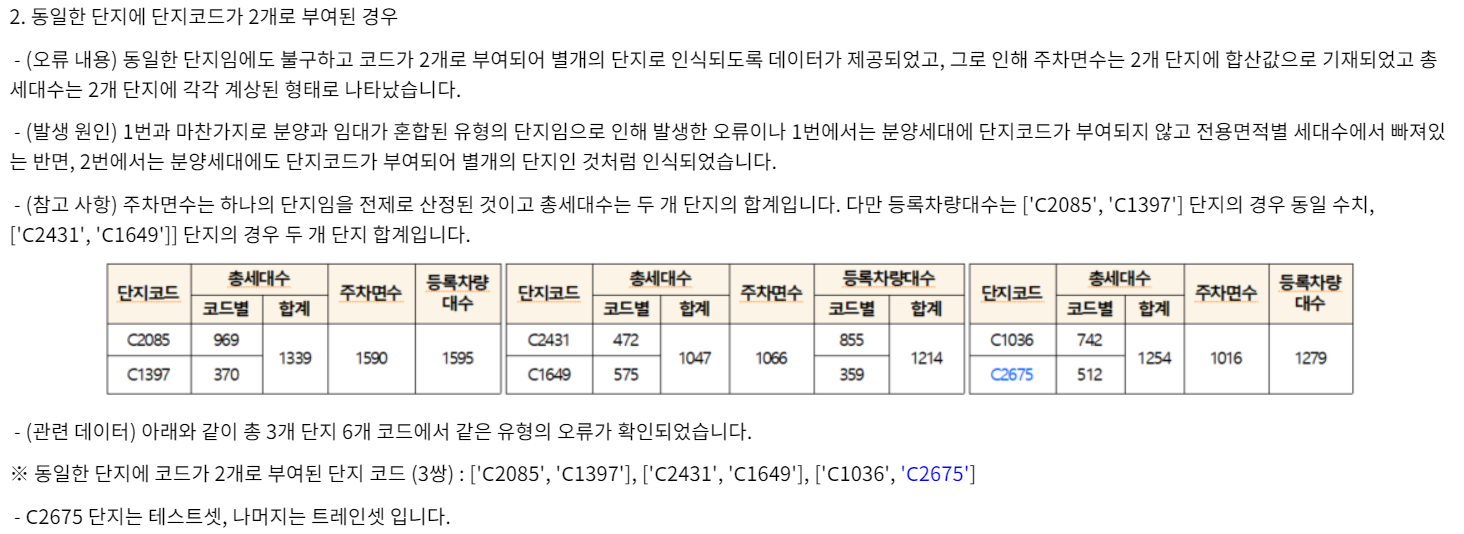

In [ ]:
train_error2_complex= ['C2085', 'C1397', 'C2431', 'C1649', 'C1036']
train = train.set_index(['단지코드'])
train = train.drop(train_error2_complex)
train = train.reset_index()

In [ ]:
# test에서는 결과 반영 암함
'''
test_error2_complex = ['C2675']
test = test.set_index(['단지코드'])
test = test.drop(test_error2_complex)
test = test.reset_index()
'''

"\ntest_error2_complex = ['C2675']\ntest = test.set_index(['단지코드'])\ntest = test.drop(test_error2_complex)\ntest = test.reset_index()\n"

### 3. 단지코드 등 기입 실수로 데이터 정제 과정에서 매칭 오류 발생

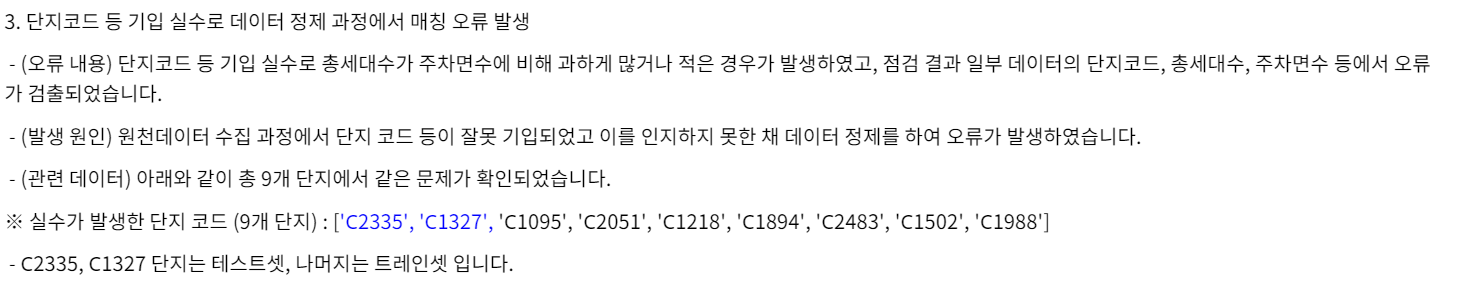

In [ ]:
train_error3_complex = ['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
train = train.set_index(['단지코드'])
train = train.drop(train_error3_complex)
train = train.reset_index()

In [ ]:
'''
test_error3_complex = ['C2335', 'C1327']
test = test.set_index(['단지코드'])
test = test.drop(test_error3_complex)
test = test.reset_index()
'''

"\ntest_error3_complex = ['C2335', 'C1327']\ntest = test.set_index(['단지코드'])\ntest = test.drop(test_error3_complex)\ntest = test.reset_index()\n"

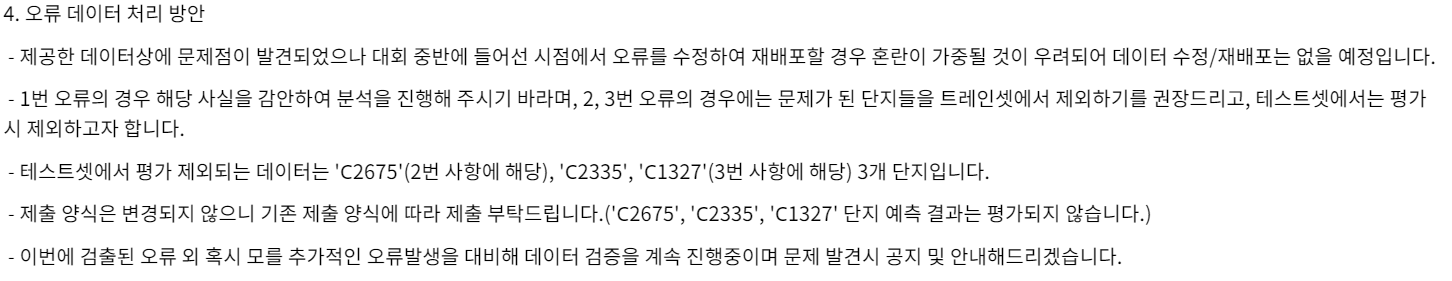

# 3. Data 전처리

In [ ]:
train_eda = train.copy(deep= True)

In [ ]:
train_eda.head(10)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000,82940,0.0,3.0,624.0,205.0
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000,107130,0.0,3.0,624.0,205.0
2,C2515,545,아파트,경상남도,국민임대,39.60,20,17.0,A,12672000,107130,0.0,3.0,624.0,205.0
3,C2515,545,아파트,경상남도,국민임대,46.90,38,17.0,A,18433000,149760,0.0,3.0,624.0,205.0
4,C2515,545,아파트,경상남도,국민임대,46.90,19,17.0,A,18433000,149760,0.0,3.0,624.0,205.0
5,C2515,545,아파트,경상남도,국민임대,51.97,106,17.0,A,23042000,190090,0.0,3.0,624.0,205.0
6,C2515,545,아파트,경상남도,국민임대,51.97,26,17.0,A,23042000,190090,0.0,3.0,624.0,205.0
7,C1407,1216,아파트,대전광역시,국민임대,30.95,288,13.0,A,15620000,127350,1.0,1.0,1285.0,1064.0
8,C1407,1216,아파트,대전광역시,국민임대,30.99,68,13.0,A,15620000,127350,1.0,1.0,1285.0,1064.0
9,C1407,1216,아파트,대전광역시,국민임대,30.99,34,13.0,A,15620000,127350,1.0,1.0,1285.0,1064.0


In [ ]:
train_eda['실세대수'] = train_eda['총세대수'] - train_eda['공가수']

In [ ]:
test['실세대수'] = test['총세대수'] - test['공가수']

## 1. 임대건물구분(아파트, 아파트+상가)

In [ ]:
train_eda['임대건물구분'].unique()

array(['아파트', '상가'], dtype=object)

In [ ]:
# 같은 단지내에 임대건물 구분이 2가지인 경우
apt_shop_list = []
apt_only_list = []
for complex_ in train_eda['단지코드'].unique().tolist():
    if len(train_eda[train_eda['단지코드'] == complex_]['임대건물구분'].unique()) != 1:
        apt_shop_list.append(complex_)
    else:
        apt_only_list.append(complex_)

In [ ]:
# 상가 보유 단지 수
len(apt_shop_list)

32

In [ ]:
# 아파트만 있는 단지수
len(apt_only_list)

370

In [ ]:
train_eda = train_eda.set_index(['단지코드'])
# 임대건물구분이 아파트만 있는 경우 0
train_eda.loc[apt_only_list,'임대건물구분'] = 0
# 임대건물구분이 아파트와 상가로 되어있는 경우 1
train_eda.loc[apt_shop_list,'임대건물구분'] = 1
train_eda = train_eda.reset_index()

In [ ]:
train_eda['임대건물구분'] = train_eda['임대건물구분'].astype('int')

In [ ]:
train_eda.sample(5)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,실세대수
1436,C1022,389,0,경기도,국민임대,46.90,83,4.0,A,24665000,221980,0.0,4.0,352.0,450.0,385.0
2750,C1732,264,0,광주광역시,행복주택,44.97,106,17.0,L,38330000,201230,0.0,3.0,188.0,267.0,247.0
1096,C2492,594,0,경상북도,국민임대,36.66,90,23.0,A,8738000,86140,0.0,5.0,480.0,585.0,571.0
2224,C1848,532,0,광주광역시,공공임대(10년),51.87,150,9.0,A,31963000,455600,0.0,3.0,660.0,625.0,523.0
2699,C2059,26,0,경기도,행복주택,16.34,3,1.0,L,27961000,116000,1.0,3.0,13.0,13.0,25.0


In [ ]:
# 세대당 등록차량수
train_eda['세대당_주차대수'] = train_eda['등록차량수'] / train_eda['실세대수']

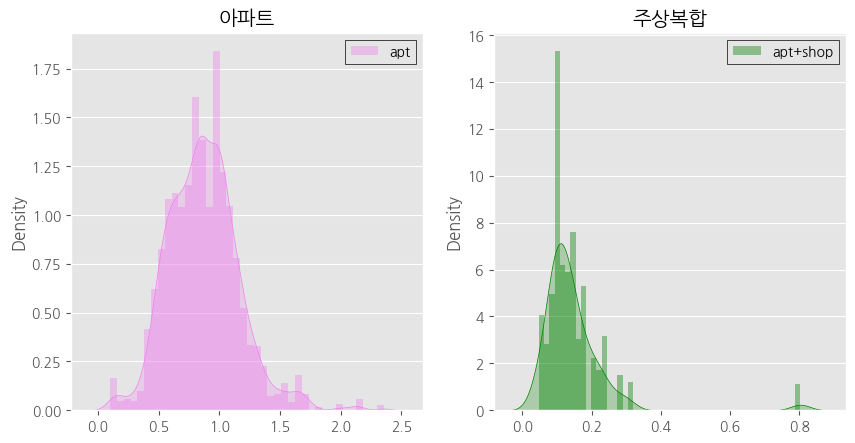

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5), dpi=100)
colors = ['violet', 'green']
for i in train_eda['임대건물구분'].unique():
    sns.distplot(train_eda[train_eda['임대건물구분'] == i]['세대당_주차대수'],
                 hist = True,
                 color = colors[i],
                 kde_kws = {'shade': True}, 
                 label = ['apt', 'apt+shop'][i],
                 ax = axes.flat[i])
    
    axes.flat[i].set_title(['아파트', '주상복합'][i])
        
    axes.flat[i].set_xlabel('')
    axes.flat[i].grid(axis = 'x',
                      linestyle = '--')
    axes.flat[i].legend(frameon=True,
                        framealpha=1,
                        shadow=False, 
                        fancybox=False,
                        edgecolor='black')

In [ ]:
# plt.figure(figsize=(10,5))
# plt.title('APT')
# sns.distplot(train_eda[train_eda['임대건물구분'] == 0]['세대당 주차대수'])
# plt.xlabel('parking_ratio')
# plt.ylabel('Dense')

In [ ]:
# plt.figure(figsize=(10,5))
# plt.title('APT+SHOP')
# sns.distplot(train_eda[train_eda['임대건물구분'] == 1]['세대당 주차대수'])
# plt.xlabel('parking_ratio')
# plt.ylabel('Dense')

## 2. 주차 규정

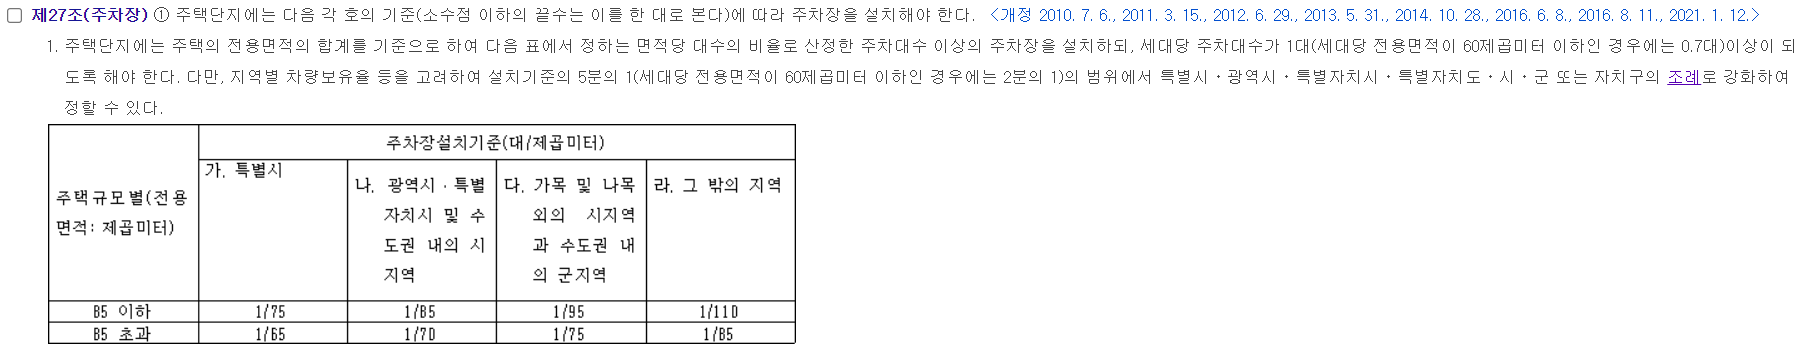

In [ ]:
# 구차규정에 따른 지역을 구분
special_city = ['서울특별시']
metropolitan_city = ['세종특별자치시', '광주광역시', '부산광역시', '울산광역시', '대전광역시', '대구광역시']
else_city = ['경상남도', '경기도', '전라북도', '강원도', '충청남도', '제주특별자치도', '충청북도', '전라남도', '경상북도']

In [ ]:
# 주차 규정
def parking_rule(x):
    div = 0
    if x['임대건물구분'] == 0: # only_apt 기준
        if x['전용면적'] <= 85:
            if x['지역'] in special_city: # 가. 특별시 전용면적 75 제곱미터 당 1대
                div = 75
            elif x['지역'] in metropolitan_city: # 나. 광역시, 특별자치시 전용면적 85제곱미터 당 1대
                div = 85
            else:  # 그 외는 95제곱미터당 1대
                div = 95
        else:
            if x['지역'] in special_city: # 가. 특별시 전용면적 75 제곱미터 당 1대
                div = 65
            elif x['지역'] in metropolitan_city: # 나. 광역시, 특별자치시 전용면적 85제곱미터 당 1대
                div = 70
            else:  # 그 외는 95제곱미터당 1대
                div = 75
    else: # 상가보유단지 기준 다르게
        div = 150
    return float(x['전용면적'] / div)

In [ ]:
train_eda[['주차장_설치기준']] = train_eda.apply(lambda x: parking_rule(x), axis = 1)

In [ ]:
train_eda.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,실세대수,세대당_주차대수,주차장_설치기준
0,C2515,545,0,경상남도,국민임대,33.48,276,17.0,A,9216000,82940,0.0,3.0,624.0,205.0,528.0,0.388258,0.352421
1,C2515,545,0,경상남도,국민임대,39.60,60,17.0,A,12672000,107130,0.0,3.0,624.0,205.0,528.0,0.388258,0.416842
2,C2515,545,0,경상남도,국민임대,39.60,20,17.0,A,12672000,107130,0.0,3.0,624.0,205.0,528.0,0.388258,0.416842
3,C2515,545,0,경상남도,국민임대,46.90,38,17.0,A,18433000,149760,0.0,3.0,624.0,205.0,528.0,0.388258,0.493684
4,C2515,545,0,경상남도,국민임대,46.90,19,17.0,A,18433000,149760,0.0,3.0,624.0,205.0,528.0,0.388258,0.493684


In [ ]:
train_eda['전용면적별_주차기준_예상등록수'] = train_eda['전용면적별세대수'] * train_eda['주차장_설치기준']

In [ ]:
# 단지별 주차규정에 의한 예상 등록수
pred_by_rule = train_eda.groupby(['단지코드'])['전용면적별_주차기준_예상등록수'].sum()

In [ ]:
pred_by_rule

단지코드
C1000    251.275579
C1004    137.165133
C1005    643.542737
C1013    707.127882
C1014    434.841474
            ...    
C2663    339.944842
C2666    558.178824
C2670    276.727579
C2680    321.129474
C2692    212.785368
Name: 전용면적별_주차기준_예상등록수, Length: 402, dtype: float64

In [ ]:
train_eda = train_eda.set_index(['단지코드'])
for complex_ in pred_by_rule.index:
    train_eda.loc[complex_,'예상등록수'] = pred_by_rule[complex_]
train_eda = train_eda.reset_index(['단지코드'])

In [ ]:
train_eda.head(5)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,실세대수,세대당_주차대수,주차장_설치기준,전용면적별_주차기준_예상등록수,예상등록수
0,C2515,545,0,경상남도,국민임대,33.48,276,17.0,A,9216000,82940,0.0,3.0,624.0,205.0,528.0,0.388258,0.352421,97.268211,230.966526
1,C2515,545,0,경상남도,국민임대,39.60,60,17.0,A,12672000,107130,0.0,3.0,624.0,205.0,528.0,0.388258,0.416842,25.010526,230.966526
2,C2515,545,0,경상남도,국민임대,39.60,20,17.0,A,12672000,107130,0.0,3.0,624.0,205.0,528.0,0.388258,0.416842,8.336842,230.966526
3,C2515,545,0,경상남도,국민임대,46.90,38,17.0,A,18433000,149760,0.0,3.0,624.0,205.0,528.0,0.388258,0.493684,18.760000,230.966526
4,C2515,545,0,경상남도,국민임대,46.90,19,17.0,A,18433000,149760,0.0,3.0,624.0,205.0,528.0,0.388258,0.493684,9.380000,230.966526


In [ ]:
train_eda.drop(columns=['주차장_설치기준', '전용면적별_주차기준_예상등록수'], axis=1, inplace=True)

In [ ]:
train_eda.corr()

,총세대수,임대건물구분,전용면적,전용면적별세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,실세대수,세대당_주차대수,예상등록수
총세대수,1.000000,0.361708,0.043609,0.097151,0.064366,0.214824,-0.001768,0.524382,0.334179,0.999792,-0.336564,0.636498
임대건물구분,0.361708,1.000000,-0.012953,-0.217795,-0.278505,0.234624,0.005543,-0.453988,-0.492570,0.367804,-0.755784,-0.282665
전용면적,0.043609,-0.012953,1.000000,-0.031547,-0.079716,-0.003461,-0.006126,0.054441,0.094875,0.045287,0.126974,0.124881
전용면적별세대수,0.097151,-0.217795,-0.031547,1.000000,0.157721,-0.060358,0.045017,0.288665,0.256273,0.094033,0.155901,0.270019
공가수,0.064366,-0.278505,-0.079716,0.157721,1.000000,-0.098100,0.036501,0.299978,0.122897,0.043988,0.035218,0.176690
도보 10분거리 내 지하철역 수(환승노선 수 반영),0.214824,0.234624,-0.003461,-0.060358,-0.098100,1.000000,0.099898,-0.048395,-0.101481,0.217066,-0.196308,0.040441
도보 10분거리 내 버스정류장 수,-0.001768,0.005543,-0.006126,0.045017,0.036501,0.099898,1.000000,0.077616,0.107344,-0.002517,0.025527,0.071794
단지내주차면수,0.524382,-0.453988,0.054441,0.288665,0.299978,-0.048395,0.077616,1.000000,0.857329,0.518829,0.376683,0.913817
등록차량수,0.334179,-0.492570,0.094875,0.256273,0.122897,-0.101481,0.107344,0.857329,1.000000,0.332036,0.650201,0.860664
실세대수,0.999792,0.367804,0.045287,0.094033,0.043988,0.217066,-0.002517,0.518829,0.332036,1.000000,-0.337657,0.633590


## 3. only_apt, mixed_use_apt 분포가 다르므로 이상치를 다르게 적용

In [ ]:
# only_apt 이상치 제거
q1 = train_eda[train_eda['임대건물구분'] == 0]['세대당_주차대수'].quantile(0.25)
q3 = train_eda[train_eda['임대건물구분'] == 0]['세대당_주차대수'].quantile(0.75)
print(f'q1 : {q1}, q3 : {q3}')
iqr = q3 - q1
lower_bound = q1 - (iqr * 1.5)
upper_bound = q3 + (iqr * 1.5)
print(f'lower_bound : {lower_bound}, upper_bound : {upper_bound}')
mask = (train_eda[train_eda['임대건물구분'] == 0]['세대당_주차대수'] >= lower_bound) & (train_eda[train_eda['임대건물구분'] == 0]['세대당_주차대수'] <= upper_bound)
only_apt = train_eda[train_eda['임대건물구분'] == 0][mask]

q1 : 0.6626776364996261, q3 : 1.0299003322259137
lower_bound : 0.11184359291019463, upper_bound : 1.5807343758153451


In [ ]:
# mixed_use_apt 이상치 제거
q1 = train_eda[train_eda['임대건물구분'] == 1]['세대당_주차대수'].quantile(0.25)
q3 = train_eda[train_eda['임대건물구분'] == 1]['세대당_주차대수'].quantile(0.75)
print(f'q1 : {q1}, q3 : {q3}')
iqr = q3 - q1
lower_bound = q1 - (iqr * 1.5)
upper_bound = q3 + (iqr * 1.5)
print(f'lower_bound : {lower_bound}, upper_bound : {upper_bound}')
mask = (train_eda[train_eda['임대건물구분'] == 1]['세대당_주차대수'] >= lower_bound) & (train_eda[train_eda['임대건물구분'] == 1]['세대당_주차대수'] <= upper_bound)
mixed_use_apt = train_eda[train_eda['임대건물구분'] == 1][mask]

q1 : 0.09591836734693877, q3 : 0.16002044989775052
lower_bound : -0.00023475647927885535, upper_bound : 0.25617357372396815


In [ ]:
only_apt.shape, mixed_use_apt.shape

((2115, 18), (614, 18))

In [ ]:
train_eda = pd.concat([only_apt, mixed_use_apt])

In [ ]:
train_eda.sample(5)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,실세대수,세대당_주차대수,예상등록수
1341,C2596,470,0,경기도,국민임대,36.91,112,15.0,A,17102000,142310,1.0,7.0,405.0,480.0,455.0,1.054945,223.018316
2749,C1732,264,0,광주광역시,행복주택,26.70,34,17.0,L,22870000,120060,0.0,3.0,188.0,267.0,247.0,1.080972,93.242118
1783,C1448,1116,0,광주광역시,국민임대,46.85,80,25.0,A,26014000,143680,0.0,2.0,1050.0,1284.0,1091.0,1.176902,652.252000
281,C1859,2424,1,대전광역시,임대상가,38.04,1,1.0,D,NaN,NaN,1.0,4.0,487.0,116.0,2423.0,0.047875,453.660600
1546,C1375,757,0,경상남도,국민임대,46.91,63,21.0,A,22471000,137310,0.0,12.0,761.0,754.0,736.0,1.024457,428.053684


## 4. 임대보증금 & 임대료

In [ ]:
train_eda.info() # '임대보증금'이 object인게 이상함|

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2729 entries, 0 to 818
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2729 non-null   object 
 1   총세대수                          2729 non-null   int64  
 2   임대건물구분                        2729 non-null   int32  
 3   지역                            2729 non-null   object 
 4   공급유형                          2729 non-null   object 
 5   전용면적                          2729 non-null   float64
 6   전용면적별세대수                      2729 non-null   int64  
 7   공가수                           2729 non-null   float64
 8   자격유형                          2729 non-null   object 
 9   임대보증금                         2203 non-null   object 
 10  임대료                           2203 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2550 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2729 non-null   float64
 13  단지내주

### 1. '-' 값 대체하기

#### 1) Train

In [ ]:
train_error_value_list = []
for value in train_eda['임대보증금']:
    try:
        int(value)
    except:
        train_error_value_list.append(value)

In [ ]:
set(train_error_value_list)

{'-', nan}

In [ ]:
train_eda[train_eda['임대보증금'] == '-']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,실세대수,세대당_주차대수,예상등록수
2427,C1326,1934,0,부산광역시,국민임대,24.72,472,43.0,H,-,-,0.0,4.0,1670.0,1153.0,1891.0,0.609730,727.508941
2428,C1326,1934,0,부산광역시,국민임대,24.79,104,43.0,H,-,-,0.0,4.0,1670.0,1153.0,1891.0,0.609730,727.508941
2429,C1326,1934,0,부산광역시,국민임대,26.83,590,43.0,H,-,-,0.0,4.0,1670.0,1153.0,1891.0,0.609730,727.508941
2430,C1326,1934,0,부산광역시,국민임대,37.70,464,43.0,H,-,-,0.0,4.0,1670.0,1153.0,1891.0,0.609730,727.508941
2431,C1326,1934,0,부산광역시,국민임대,46.94,304,43.0,H,-,-,0.0,4.0,1670.0,1153.0,1891.0,0.609730,727.508941
2557,C1786,480,0,강원도,행복주택,16.91,156,25.0,K,-,-,0.0,3.0,338.0,345.0,455.0,0.758242,129.205053
2558,C1786,480,0,강원도,행복주택,26.90,136,25.0,K,-,-,0.0,3.0,338.0,345.0,455.0,0.758242,129.205053
2559,C1786,480,0,강원도,행복주택,26.90,72,25.0,K,-,-,0.0,3.0,338.0,345.0,455.0,0.758242,129.205053
2560,C1786,480,0,강원도,행복주택,26.90,24,25.0,K,-,-,0.0,3.0,338.0,345.0,455.0,0.758242,129.205053
2772,C2186,916,0,대구광역시,국민임대,29.17,238,0.0,H,-,-,0.0,8.0,664.0,744.0,916.0,0.812227,366.540118


In [ ]:
train_eda[train_eda['단지코드'] == 'C1326']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,실세대수,세대당_주차대수,예상등록수
2427,C1326,1934,0,부산광역시,국민임대,24.72,472,43.0,H,-,-,0.0,4.0,1670.0,1153.0,1891.0,0.60973,727.508941
2428,C1326,1934,0,부산광역시,국민임대,24.79,104,43.0,H,-,-,0.0,4.0,1670.0,1153.0,1891.0,0.60973,727.508941
2429,C1326,1934,0,부산광역시,국민임대,26.83,590,43.0,H,-,-,0.0,4.0,1670.0,1153.0,1891.0,0.60973,727.508941
2430,C1326,1934,0,부산광역시,국민임대,37.70,464,43.0,H,-,-,0.0,4.0,1670.0,1153.0,1891.0,0.60973,727.508941
2431,C1326,1934,0,부산광역시,국민임대,46.94,304,43.0,H,-,-,0.0,4.0,1670.0,1153.0,1891.0,0.60973,727.508941


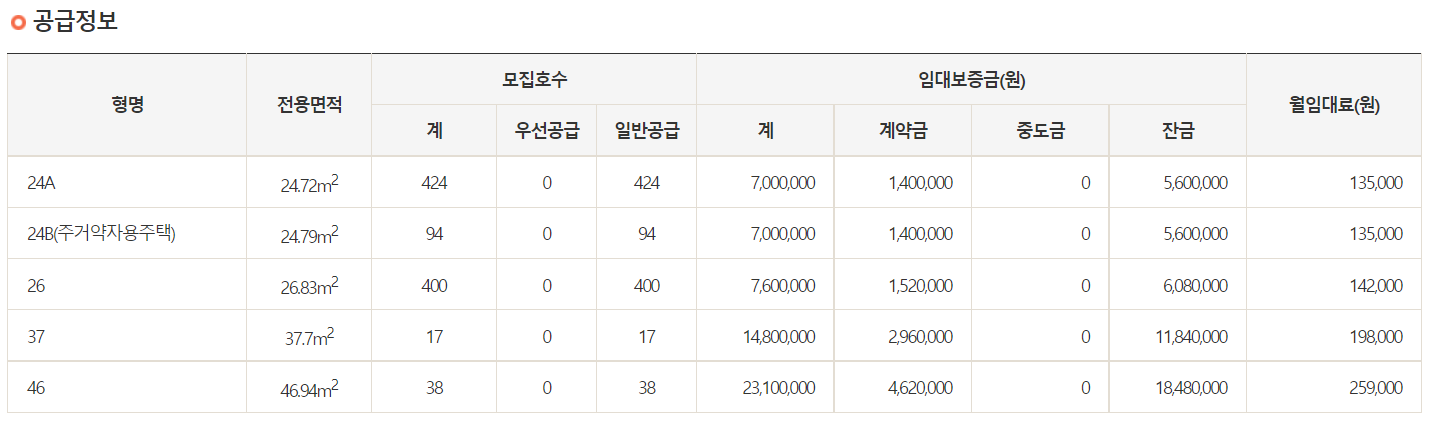

In [ ]:
# 전용면적 24.72
train_eda.loc[(train_eda['단지코드'] == 'C1326') & (train_eda['전용면적'] == 24.72), '임대보증금'] = 7000000
train_eda.loc[(train_eda['단지코드'] == 'C1326') & (train_eda['전용면적'] == 24.72), '임대료'] = 135000
# 전용면적 24.79
train_eda.loc[(train_eda['단지코드'] == 'C1326') & (train_eda['전용면적'] == 24.79), '임대보증금'] = 7000000
train_eda.loc[(train_eda['단지코드'] == 'C1326') & (train_eda['전용면적'] == 24.79), '임대료'] = 135000
# 전용면적 26.83
train_eda.loc[(train_eda['단지코드'] == 'C1326') & (train_eda['전용면적'] == 26.83), '임대보증금'] = 7600000
train_eda.loc[(train_eda['단지코드'] == 'C1326') & (train_eda['전용면적'] == 26.83), '임대료'] = 142000
# 전용면적 37.7
train_eda.loc[(train_eda['단지코드'] == 'C1326') & (train_eda['전용면적'] == 37.7), '임대보증금'] = 14800000
train_eda.loc[(train_eda['단지코드'] == 'C1326') & (train_eda['전용면적'] == 37.7), '임대료'] = 198000
# 전용면적 46.94
train_eda.loc[(train_eda['단지코드'] == 'C1326') & (train_eda['전용면적'] == 46.94), '임대보증금'] = 23100000
train_eda.loc[(train_eda['단지코드'] == 'C1326') & (train_eda['전용면적'] == 46.94), '임대료'] = 259000

In [ ]:
train_eda[train_eda['단지코드'] == 'C1786']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,실세대수,세대당_주차대수,예상등록수
2557,C1786,480,0,강원도,행복주택,16.91,156,25.0,K,-,-,0.0,3.0,338.0,345.0,455.0,0.758242,129.205053
2558,C1786,480,0,강원도,행복주택,26.90,136,25.0,K,-,-,0.0,3.0,338.0,345.0,455.0,0.758242,129.205053
2559,C1786,480,0,강원도,행복주택,26.90,72,25.0,K,-,-,0.0,3.0,338.0,345.0,455.0,0.758242,129.205053
2560,C1786,480,0,강원도,행복주택,26.90,24,25.0,K,-,-,0.0,3.0,338.0,345.0,455.0,0.758242,129.205053
2561,C1786,480,0,강원도,행복주택,36.91,92,25.0,J,30560000,145160,0.0,3.0,338.0,345.0,455.0,0.758242,129.205053


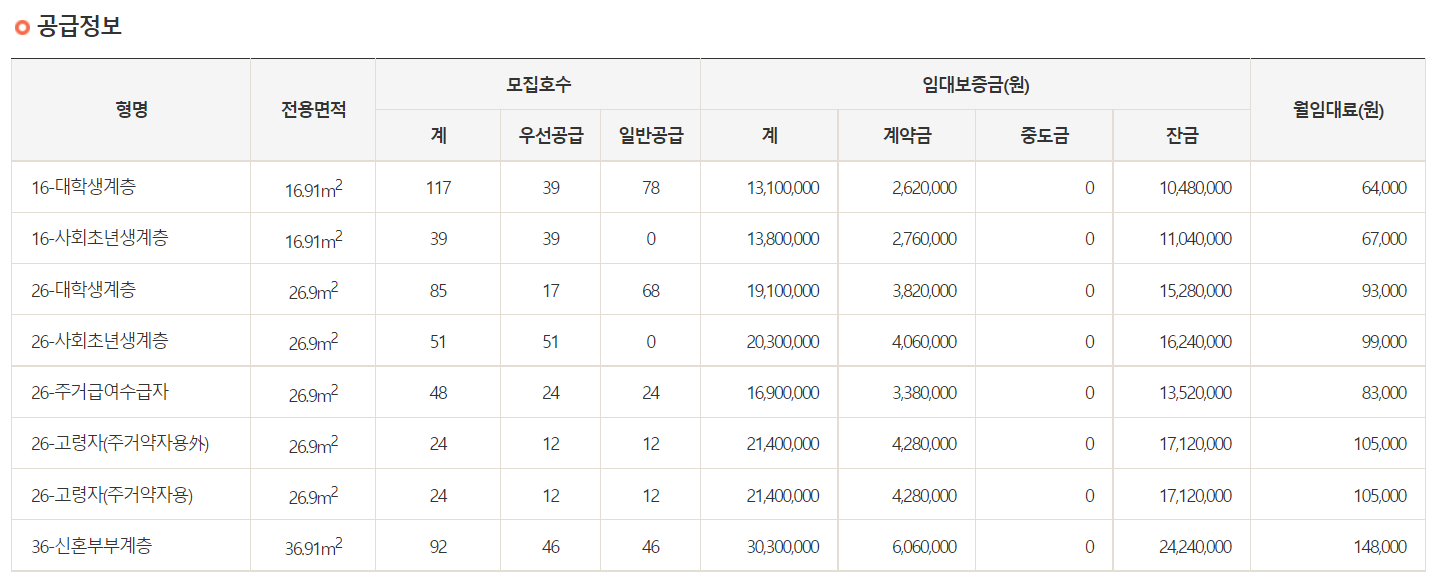

In [ ]:
# 전용면적 16.91 
train_eda.loc[(train['단지코드'] == 'C1786') & (train_eda['전용면적'] == 16.91), '임대보증금'] = 13450000
train_eda.loc[(train['단지코드'] == 'C1786') & (train_eda['전용면적'] == 16.91), '임대료'] = 65500
# 전용면적 26.9
train_eda.loc[(train['단지코드'] == 'C1786') & (train_eda['전용면적'] == 26.9), '임대보증금'] = 19700000
train_eda.loc[(train['단지코드'] == 'C1786') & (train_eda['전용면적'] == 26.9), '임대료'] = 96000
# 전용면적 26.9
train_eda.loc[(train['단지코드'] == 'C1786') & (train_eda['전용면적'] == 26.9), '임대보증금'] = 19150000
train_eda.loc[(train['단지코드'] == 'C1786') & (train_eda['전용면적'] == 26.9), '임대료'] = 94000
# 전용면적 26.9
train_eda.loc[(train['단지코드'] == 'C1786') & (train_eda['전용면적'] == 26.9), '임대보증금'] = 21400000
train_eda.loc[(train['단지코드'] == 'C1786') & (train_eda['전용면적'] == 26.9), '임대료'] = 105000

In [ ]:
train_eda[train_eda['단지코드'] == 'C2186']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,실세대수,세대당_주차대수,예상등록수
2772,C2186,916,0,대구광역시,국민임대,29.17,238,0.0,H,-,-,0.0,8.0,664.0,744.0,916.0,0.812227,366.540118
2773,C2186,916,0,대구광역시,국민임대,29.34,38,0.0,H,-,-,0.0,8.0,664.0,744.0,916.0,0.812227,366.540118
2774,C2186,916,0,대구광역시,국민임대,37.43,220,0.0,H,-,-,0.0,8.0,664.0,744.0,916.0,0.812227,366.540118
2775,C2186,916,0,대구광역시,국민임대,46.51,188,0.0,H,25981000,248630,0.0,8.0,664.0,744.0,916.0,0.812227,366.540118
2776,C2186,916,0,대구광역시,영구임대,26.37,219,0.0,C,13126000,105870,0.0,8.0,664.0,744.0,916.0,0.812227,366.540118
2777,C2186,916,0,대구광역시,영구임대,26.54,13,0.0,C,13164000,106190,0.0,8.0,664.0,744.0,916.0,0.812227,366.540118


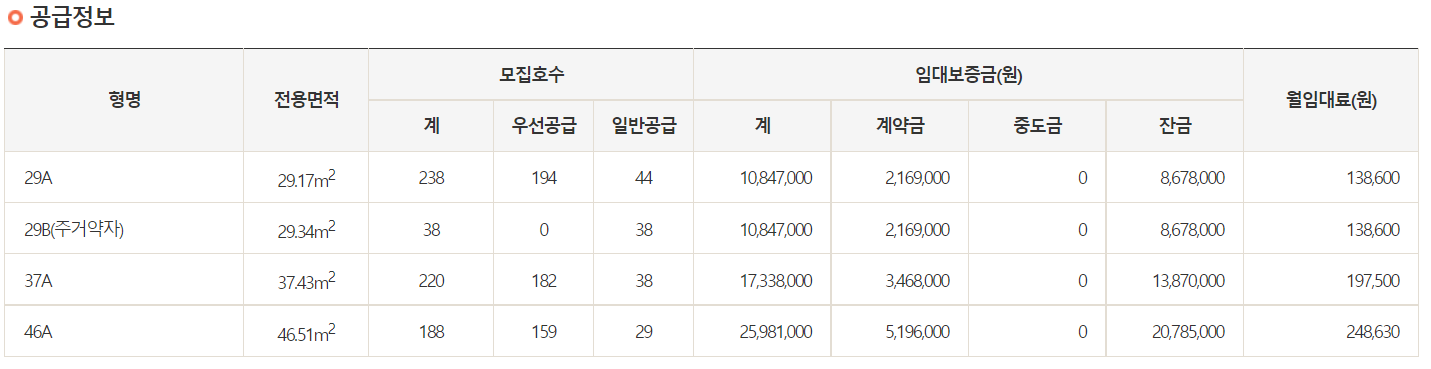

In [ ]:
# 전용면적 29.17
train_eda.loc[(train_eda['단지코드'] == 'C2186') & (train_eda['전용면적'] == 29.17), '임대보증금'] = 10847000
train_eda.loc[(train_eda['단지코드'] == 'C2186') & (train_eda['전용면적'] == 29.17), '임대료'] = 138600
# 전용면적 29.34
train_eda.loc[(train_eda['단지코드'] == 'C2186') & (train_eda['전용면적'] == 29.34), '임대보증금'] = 10847000
train_eda.loc[(train_eda['단지코드'] == 'C2186') & (train_eda['전용면적'] == 29.34), '임대료'] = 138600
# 전용면적 37.43
train_eda.loc[(train_eda['단지코드'] == 'C2186') & (train_eda['전용면적'] == 37.43), '임대보증금'] = 17338000
train_eda.loc[(train_eda['단지코드'] == 'C2186') & (train_eda['전용면적'] == 37.43), '임대료'] = 197500

#### 임대보증금은 - 이 아니지만 임대료는 - 인경우 @@@@ 어캐하지@@@@

In [ ]:
train_eda[(train_eda['임대보증금'] != '-') & (train_eda['임대료'] == '-')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,실세대수,세대당_주차대수,예상등록수
2051,C1039,790,0,서울특별시,장기전세,51.32,126,13.0,A,187694000,-,0.0,3.0,673.0,645.0,777.0,0.830116,464.528667
2052,C1039,790,0,서울특별시,장기전세,59.88,49,13.0,A,213863000,-,0.0,3.0,673.0,645.0,777.0,0.830116,464.528667
2053,C1039,790,0,서울특별시,장기전세,59.94,75,13.0,A,213863000,-,0.0,3.0,673.0,645.0,777.0,0.830116,464.528667


In [ ]:
train_eda['임대료'] = train_eda['임대료'].replace('-',0)

#### 2) Test

In [ ]:
test_error_value_list = []
for value in test['임대보증금']:
    try:
        int(value)
    except:
        test_error_value_list.append(value)

In [ ]:
set(test_error_value_list)

{'-', nan}

In [ ]:
test[test['임대보증금'] == '-']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,실세대수
1005,C2152,120,아파트,강원도,영구임대,24.83,66,9.0,C,-,-,0.0,1.0,40.0,111.0
1006,C2152,120,아파트,강원도,영구임대,33.84,54,9.0,C,-,-,0.0,1.0,40.0,111.0
1014,C1267,670,아파트,경상남도,행복주택,16.94,50,38.0,L,-,-,0.0,1.0,467.0,632.0
1015,C1267,670,아파트,경상남도,행복주택,26.85,66,38.0,L,-,-,0.0,1.0,467.0,632.0
1016,C1267,670,아파트,경상남도,행복주택,26.85,8,38.0,L,-,-,0.0,1.0,467.0,632.0
1017,C1267,670,아파트,경상남도,행복주택,36.77,126,38.0,L,-,-,0.0,1.0,467.0,632.0


In [ ]:
test[test['단지코드'] == 'C2152']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,실세대수
1005,C2152,120,아파트,강원도,영구임대,24.83,66,9.0,C,-,-,0.0,1.0,40.0,111.0
1006,C2152,120,아파트,강원도,영구임대,33.84,54,9.0,C,-,-,0.0,1.0,40.0,111.0


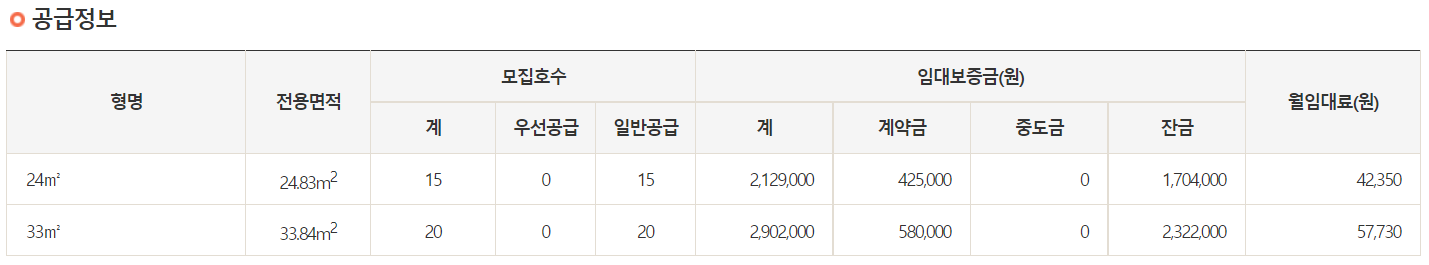

In [ ]:
# 전용면적 24.83
test.loc[(test['단지코드'] == 'C2152') & (test['전용면적'] == 24.83), '임대보증금'] = 2129000
test.loc[(test['단지코드'] == 'C2152') & (test['전용면적'] == 24.83), '임대료'] = 42350
# 전용면적 33.84
test.loc[(test['단지코드'] == 'C2152') & (test['전용면적'] == 33.84), '임대보증금'] = 2902000
test.loc[(test['단지코드'] == 'C2152') & (test['전용면적'] == 33.84), '임대료'] = 57730

In [ ]:
test[test['단지코드'] == 'C1267']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,실세대수
1007,C1267,670,아파트,경상남도,국민임대,24.87,28,38.0,H,6882000,104370,0.0,1.0,467.0,632.0
1008,C1267,670,아파트,경상남도,국민임대,24.99,90,38.0,H,6882000,104370,0.0,1.0,467.0,632.0
1009,C1267,670,아파트,경상남도,국민임대,24.99,12,38.0,H,6882000,104370,0.0,1.0,467.0,632.0
1010,C1267,670,아파트,경상남도,국민임대,46.72,68,38.0,H,24420000,219230,0.0,1.0,467.0,632.0
1011,C1267,670,아파트,경상남도,국민임대,46.72,112,38.0,H,24420000,219230,0.0,1.0,467.0,632.0
1012,C1267,670,아파트,경상남도,영구임대,22.86,96,38.0,C,10876000,89230,0.0,1.0,467.0,632.0
1013,C1267,670,아파트,경상남도,영구임대,22.86,14,38.0,C,10876000,89230,0.0,1.0,467.0,632.0
1014,C1267,670,아파트,경상남도,행복주택,16.94,50,38.0,L,-,-,0.0,1.0,467.0,632.0
1015,C1267,670,아파트,경상남도,행복주택,26.85,66,38.0,L,-,-,0.0,1.0,467.0,632.0
1016,C1267,670,아파트,경상남도,행복주택,26.85,8,38.0,L,-,-,0.0,1.0,467.0,632.0


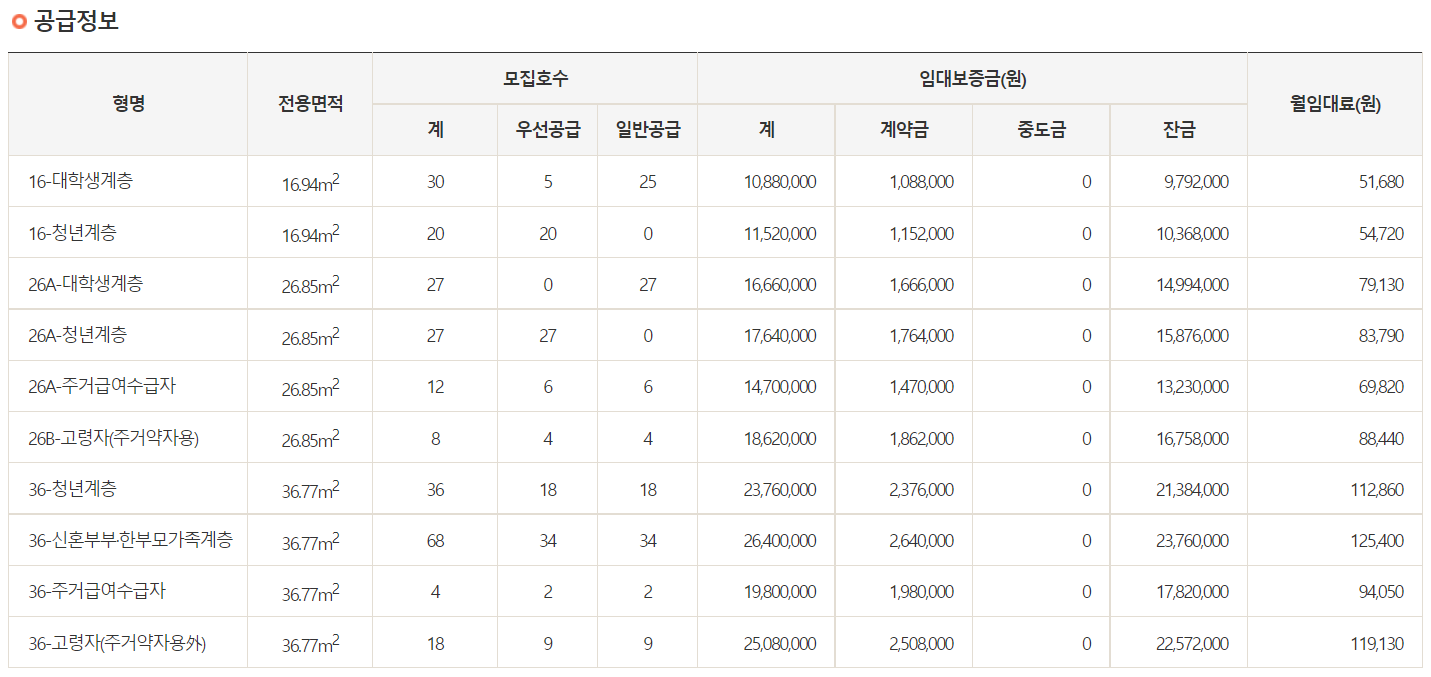

In [ ]:
# 전용면적 16.94
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 16.94), '임대보증금'] = 11200000
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 16.94), '임대료'] = 53200
# 전용면적 26.85
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 26.85), '임대보증금'] = 16333330
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 26.85), '임대료'] = 77580
# 전용면적 26.85
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 26.85), '임대보증금'] = 18620000
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 26.85), '임대료'] = 88440
# 전용면적 36.77
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 36.77), '임대보증금'] = 23760000
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 36.77), '임대료'] = 112860

### 2. 결측치 처리 (@@@진행중@@@)

#### 1) Train

In [ ]:
lease_na_df = train_eda[train_eda['임대보증금'].isna() | train_eda['임대료'].isna()]

In [ ]:
lease_na_df.sample(5)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,실세대수,세대당_주차대수,예상등록수
472,C2597,1005,1,부산광역시,임대상가,27.75,1,25.0,D,NaN,NaN,0.0,2.0,166.0,94.0,980.0,0.095918,186.760667
111,C1874,619,1,충청남도,임대상가,28.19,1,2.0,D,NaN,NaN,NaN,2.0,97.0,62.0,617.0,0.100486,114.609400
703,C1790,657,1,경상남도,임대상가,28.88,1,2.0,D,NaN,NaN,0.0,4.0,166.0,120.0,655.0,0.183206,130.323467
759,C1004,521,1,충청남도,임대상가,35.13,1,3.0,D,NaN,NaN,NaN,2.0,153.0,93.0,518.0,0.179537,137.165133
500,C2310,1988,1,부산광역시,임대상가,37.95,1,1.0,D,NaN,NaN,0.0,2.0,217.0,189.0,1987.0,0.095118,365.321933


In [ ]:
# 임대보증금과 임대료가 결측치인 경우는 자격유형이 'D' 인 경우 뿐이다
lease_na_df['자격유형'].unique()

array(['D'], dtype=object)

In [ ]:
# 자격유형이 'D' 경우가 무엇일까?
train_eda[train_eda['자격유형'] == 'D']['임대건물구분'].value_counts()

1    526
Name: 임대건물구분, dtype: int64

In [ ]:
lease_na_df['임대건물구분'].value_counts()

1    526
Name: 임대건물구분, dtype: int64

In [ ]:
# 임대보증금과 임대료가 결측치인 경우는 공급유형이 '임대상가' 또는 '공공분야' 뿐이다
lease_na_df['공급유형'].unique()

array(['임대상가'], dtype=object)

In [ ]:
lease_na_df['임대건물구분'].value_counts()

1    526
Name: 임대건물구분, dtype: int64

In [ ]:
# 임대건물구분이 상가인 경우 임대보증금과 임대료는 모두 결측치
print(lease_na_df['임대건물구분'].value_counts())
print(train_eda[train_eda['임대건물구분'] == 1].shape)

1    526
Name: 임대건물구분, dtype: int64
(614, 18)


In [ ]:
lease_na_df[lease_na_df['임대건물구분'] == 1].head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,실세대수,세대당_주차대수,예상등록수
80,C1925,600,1,강원도,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0,591.0,0.126904,115.733867
81,C1925,600,1,강원도,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0,591.0,0.126904,115.733867
82,C1925,600,1,강원도,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0,591.0,0.126904,115.733867
83,C1925,600,1,강원도,임대상가,72.16,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0,591.0,0.126904,115.733867
93,C1874,619,1,충청남도,임대상가,12.62,1,2.0,D,NaN,NaN,NaN,2.0,97.0,62.0,617.0,0.100486,114.609400


#### NaN값을 0으로 해도되고 아니면 지역별 평균값을 넣어도 될거 같아요!

In [ ]:
train_eda['임대보증금'] = train_eda['임대보증금'].fillna(0)
train_eda['임대료'] = train_eda['임대료'].fillna(0)

### 3. 임대보증금과 임대료와 등록차량수와의 관계

In [ ]:
train_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2729 entries, 0 to 818
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2729 non-null   object 
 1   총세대수                          2729 non-null   int64  
 2   임대건물구분                        2729 non-null   int32  
 3   지역                            2729 non-null   object 
 4   공급유형                          2729 non-null   object 
 5   전용면적                          2729 non-null   float64
 6   전용면적별세대수                      2729 non-null   int64  
 7   공가수                           2729 non-null   float64
 8   자격유형                          2729 non-null   object 
 9   임대보증금                         2729 non-null   object 
 10  임대료                           2729 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2550 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2729 non-null   float64
 13  단지내주

### 4. 단지별 평균 면적당 임대보증금과 임대료

In [ ]:
# 임대보증금과 임대료를 실수로 변환
train_eda['임대보증금'] = train_eda['임대보증금'].astype('float64')
train_eda['임대료'] = train_eda['임대료'].astype('float64')

In [ ]:
# 임대보증금 / 전용면적, 임대료 / 전용면적 을 통한 면적당 임대보증금과 임대료 산출
train_eda['면적당_임대보증금'] = train_eda['임대보증금'] / train_eda['전용면적']
train_eda['면적당_임대료'] = train_eda['임대료'] / train_eda['전용면적']

In [ ]:
# 단지별 대표 임대보증금과 임대료 가중치 평균을 통해 산출
train_eda = train_eda.set_index(['단지코드'])

for complex_ in train_eda.index.unique():
    # 단지별 면적당 임대보증금 평균값
    avg_rental_deposit = np.dot(train_eda.loc[complex_]['면적당_임대보증금'], train_eda.loc[complex_]['전용면적별세대수']) / train_eda.loc[complex_]['총세대수']
    # 단지별 면적당 임대료 평균값
    avg_rental_cost = np.dot(train_eda.loc[complex_]['면적당_임대료'], train_eda.loc[complex_]['전용면적별세대수']) / train_eda.loc[complex_]['총세대수']
    train_eda.loc[complex_, '단지평균_면적당_임대보증금'] = avg_rental_deposit
    train_eda.loc[complex_, '단지평균_면적당_임대료'] = avg_rental_cost
    
train_eda = train_eda.reset_index()

In [ ]:
train_eda.head(10)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,실세대수,세대당_주차대수,예상등록수,면적당_임대보증금,면적당_임대료,단지평균_면적당_임대보증금,단지평균_면적당_임대료
0,C2515,545,0,경상남도,국민임대,33.48,276,17.0,A,9216000.0,...,3.0,624.0,205.0,528.0,0.388258,230.966526,275268.817204,2477.299881,334865.630634,2871.531739
1,C2515,545,0,경상남도,국민임대,39.60,60,17.0,A,12672000.0,...,3.0,624.0,205.0,528.0,0.388258,230.966526,320000.000000,2705.303030,334865.630634,2871.531739
2,C2515,545,0,경상남도,국민임대,39.60,20,17.0,A,12672000.0,...,3.0,624.0,205.0,528.0,0.388258,230.966526,320000.000000,2705.303030,334865.630634,2871.531739
3,C2515,545,0,경상남도,국민임대,46.90,38,17.0,A,18433000.0,...,3.0,624.0,205.0,528.0,0.388258,230.966526,393027.718550,3193.176972,334865.630634,2871.531739
4,C2515,545,0,경상남도,국민임대,46.90,19,17.0,A,18433000.0,...,3.0,624.0,205.0,528.0,0.388258,230.966526,393027.718550,3193.176972,334865.630634,2871.531739
5,C2515,545,0,경상남도,국민임대,51.97,106,17.0,A,23042000.0,...,3.0,624.0,205.0,528.0,0.388258,230.966526,443371.175678,3657.687127,334865.630634,2871.531739
6,C2515,545,0,경상남도,국민임대,51.97,26,17.0,A,23042000.0,...,3.0,624.0,205.0,528.0,0.388258,230.966526,443371.175678,3657.687127,334865.630634,2871.531739
7,C1407,1216,0,대전광역시,국민임대,30.95,288,13.0,A,15620000.0,...,1.0,1285.0,1064.0,1203.0,0.884456,578.342118,504684.975767,4114.701131,661899.226495,4204.613069
8,C1407,1216,0,대전광역시,국민임대,30.99,68,13.0,A,15620000.0,...,1.0,1285.0,1064.0,1203.0,0.884456,578.342118,504033.559213,4109.390126,661899.226495,4204.613069
9,C1407,1216,0,대전광역시,국민임대,30.99,34,13.0,A,15620000.0,...,1.0,1285.0,1064.0,1203.0,0.884456,578.342118,504033.559213,4109.390126,661899.226495,4204.613069


## 5. 대중교통

In [ ]:
train_eda.isna().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                             0
임대료                               0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    179
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
실세대수                              0
세대당_주차대수                          0
예상등록수                             0
면적당_임대보증금                         0
면적당_임대료                           0
단지평균_면적당_임대보증금                    0
단지평균_면적당_임대료                      0
dtype: int64

In [ ]:
train_eda['지하철'] = train_eda['도보 10분거리 내 지하철역 수(환승노선 수 반영)']
train_eda.drop(columns = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)'], axis = 1, inplace = True)

In [ ]:
train_eda['버스'] = train_eda['도보 10분거리 내 버스정류장 수']
train_eda.drop(columns = ['도보 10분거리 내 버스정류장 수'], axis = 1, inplace = True)

In [ ]:
train_eda.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,등록차량수,실세대수,세대당_주차대수,예상등록수,면적당_임대보증금,면적당_임대료,단지평균_면적당_임대보증금,단지평균_면적당_임대료,지하철,버스
0,C2515,545,0,경상남도,국민임대,33.48,276,17.0,A,9216000.0,...,205.0,528.0,0.388258,230.966526,275268.817204,2477.299881,334865.630634,2871.531739,0.0,3.0
1,C2515,545,0,경상남도,국민임대,39.60,60,17.0,A,12672000.0,...,205.0,528.0,0.388258,230.966526,320000.000000,2705.303030,334865.630634,2871.531739,0.0,3.0
2,C2515,545,0,경상남도,국민임대,39.60,20,17.0,A,12672000.0,...,205.0,528.0,0.388258,230.966526,320000.000000,2705.303030,334865.630634,2871.531739,0.0,3.0
3,C2515,545,0,경상남도,국민임대,46.90,38,17.0,A,18433000.0,...,205.0,528.0,0.388258,230.966526,393027.718550,3193.176972,334865.630634,2871.531739,0.0,3.0
4,C2515,545,0,경상남도,국민임대,46.90,19,17.0,A,18433000.0,...,205.0,528.0,0.388258,230.966526,393027.718550,3193.176972,334865.630634,2871.531739,0.0,3.0


In [ ]:
train_eda['지하철'].isna().sum()

179

In [ ]:
train_eda['지하철'] = train_eda['지하철'].fillna(0)

In [ ]:
train_eda['대중교통'] = train_eda['지하철'] + train_eda['버스']

In [ ]:
train_eda.sample(5)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,실세대수,세대당_주차대수,예상등록수,면적당_임대보증금,면적당_임대료,단지평균_면적당_임대보증금,단지평균_면적당_임대료,지하철,버스,대중교통
2325,C1476,453,1,경상남도,임대상가,32.10,1,6.0,D,0.0,...,447.0,0.156600,85.050667,0.000000,0.000000,300146.840122,4501.650089,0.0,5.0,5.0
1569,C1848,532,0,광주광역시,공공임대(10년),59.89,56,9.0,A,41253000.0,...,523.0,1.195029,360.529412,688812.823510,8524.127567,668433.785470,8600.059935,0.0,3.0,3.0
399,C2133,355,0,광주광역시,국민임대,51.93,14,10.0,A,32459000.0,...,345.0,0.950725,190.035059,625052.955902,3317.542846,554381.105451,3015.708485,0.0,3.0,3.0
1449,C2389,690,0,충청북도,국민임대,51.93,135,21.0,A,23281000.0,...,669.0,0.838565,290.501053,448315.039476,3409.782399,310127.864411,2600.793859,0.0,3.0,3.0
2146,C1874,619,1,충청남도,임대상가,42.40,1,2.0,D,0.0,...,617.0,0.100486,114.609400,0.000000,0.000000,113920.101752,2535.108643,0.0,2.0,2.0


In [ ]:
train_eda[['단지코드', '실세대수', '대중교통', '등록차량수']]['단지코드'].unique().shape

(389,)

In [ ]:
df1 = train_eda[['단지코드', '실세대수', '대중교통', '등록차량수']].drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

In [ ]:
df1.sample(5)

,단지코드,실세대수,대중교통,등록차량수
1006,C2192,498.0,2.0,324.0
1890,C1565,978.0,3.0,588.0
174,C2445,784.0,4.0,334.0
154,C1866,337.0,3.0,135.0
1529,C2137,930.0,8.0,752.0


In [ ]:
# 로그를 취해 분포를 조정 0.0000001 을 더하는 이유 : 분모가 0이 되는것을 방지
df1['세대수/대중교통'] = np.log(df1['실세대수'] / (df1['대중교통'] + 0.0000001))

In [ ]:
df1.head()

,단지코드,실세대수,대중교통,등록차량수,세대수/대중교통
0,C2515,528.0,3.0,205.0,5.170484
7,C1407,1203.0,2.0,1064.0,6.399426
18,C1945,749.0,4.0,730.0,5.232445
24,C1470,682.0,2.0,553.0,5.831882
28,C1898,557.0,6.0,415.0,4.530806


In [ ]:
q1 = df1['세대수/대중교통'].quantile(0.25)
q3 = df1['세대수/대중교통'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (iqr * 1.5)
upper_bound = q3 + (iqr * 1.5)
mask = (df1['세대수/대중교통'] >= lower_bound) & (df1['세대수/대중교통'] <= upper_bound)
df1 = df1.loc[mask] # 7단지 제거

<AxesSubplot:xlabel='세대수/대중교통', ylabel='등록차량수'>

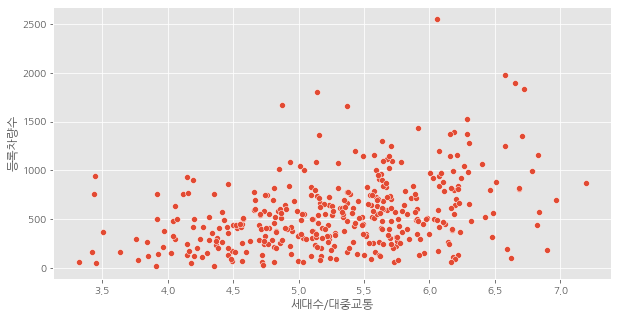

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(x = '세대수/대중교통', y = '등록차량수', data = df1)

In [ ]:
# 단지를 리스트에 담기
apt_complex = df1['단지코드'].tolist()
# 세대수 / 대중교통 값 담기
public_transform_ratio = df1['세대수/대중교통'].tolist()

In [ ]:
train_eda = train_eda.set_index(['단지코드'])
for complex_, ratio_ in zip(apt_complex, public_transform_ratio):
    train_eda.loc[complex_, '세대수/대중교통'] = ratio_
train_eda  = train_eda.reset_index()

In [ ]:
train_eda = train_eda.dropna(axis= 0 )

In [ ]:
train_eda.sample(5)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,세대당_주차대수,예상등록수,면적당_임대보증금,면적당_임대료,단지평균_면적당_임대보증금,단지평균_면적당_임대료,지하철,버스,대중교통,세대수/대중교통
2690,C1875,1003,1,충청남도,임대상가,23.40,1,5.0,D,0.0,...,0.209419,182.615533,0.000000e+00,0.000000,116858.118799,2600.520563,0.0,8.0,8.0,4.826312
1640,C2539,396,0,충청남도,영구임대,26.81,58,8.0,E,45995000.0,...,0.587629,143.546947,1.715591e+06,893.323387,454144.819265,3303.644585,0.0,2.0,2.0,5.267858
1861,C1786,480,0,강원도,행복주택,16.91,156,25.0,K,13450000.0,...,0.758242,129.205053,7.953873e+05,3873.447664,801703.734526,3899.276086,0.0,3.0,3.0,5.021685
819,C1143,693,0,경기도,국민임대,45.53,238,3.0,A,20333000.0,...,0.915942,289.454421,4.465847e+05,4521.853723,426794.898161,4514.886295,1.0,11.0,12.0,4.051785
2531,C1439,1755,1,부산광역시,임대상가,16.57,1,29.0,D,0.0,...,0.099652,328.631600,0.000000e+00,0.000000,213825.604724,2955.215377,1.0,3.0,4.0,6.067267


In [ ]:
train_eda.corr()

,총세대수,임대건물구분,전용면적,전용면적별세대수,공가수,임대보증금,임대료,단지내주차면수,등록차량수,실세대수,세대당_주차대수,예상등록수,면적당_임대보증금,면적당_임대료,단지평균_면적당_임대보증금,단지평균_면적당_임대료,지하철,버스,대중교통,세대수/대중교통
총세대수,1.000000,0.317130,0.031990,0.124727,0.128956,-0.061750,-0.096424,0.539854,0.384615,0.999764,-0.325141,0.670409,-0.046706,-0.086694,0.027836,0.121281,0.260101,0.079549,0.119305,0.590143
임대건물구분,0.317130,1.000000,-0.011407,-0.215619,-0.242802,-0.530559,-0.592915,-0.479858,-0.515275,0.323276,-0.787850,-0.304955,-0.534300,-0.686989,-0.438852,-0.290349,0.208478,0.021131,0.054346,0.157761
전용면적,0.031990,-0.011407,1.000000,-0.032184,-0.076564,0.109792,0.169527,0.035974,0.072714,0.033752,0.109438,0.105582,-0.017025,0.031403,-0.048742,0.033838,0.001797,0.007461,0.007517,0.032634
전용면적별세대수,0.124727,-0.215619,-0.032184,1.000000,0.154800,0.120727,0.196398,0.298813,0.268009,0.121655,0.155602,0.286812,0.130178,0.270740,0.082303,0.109743,-0.054659,0.058377,0.047646,0.093079
공가수,0.128956,-0.242802,-0.076564,0.154800,1.000000,0.222805,0.025464,0.325571,0.145967,0.107361,0.031731,0.214916,0.338121,0.109788,0.372846,-0.010713,-0.099842,0.036676,0.019288,0.110628
임대보증금,-0.061750,-0.530559,0.109792,0.120727,0.222805,1.000000,0.583119,0.395300,0.433744,-0.066796,0.495511,0.344537,0.897535,0.518360,0.694212,0.405046,-0.045811,0.144822,0.132794,-0.107157
임대료,-0.096424,-0.592915,0.169527,0.196398,0.025464,0.583119,1.000000,0.461518,0.558614,-0.097232,0.661772,0.456583,0.393027,0.893113,0.324937,0.742917,-0.030026,0.075757,0.068480,-0.084168
단지내주차면수,0.539854,-0.479858,0.035974,0.298813,0.325571,0.395300,0.461518,1.000000,0.864690,0.534114,0.376307,0.912512,0.357536,0.501956,0.334130,0.397748,-0.026949,0.115016,0.106996,0.362072
등록차량수,0.384615,-0.515275,0.072714,0.268009,0.145967,0.433744,0.558614,0.864690,1.000000,0.382411,0.632513,0.855094,0.346463,0.550434,0.306560,0.436698,-0.089237,0.130898,0.112252,0.253359
실세대수,0.999764,0.323276,0.033752,0.121655,0.107361,-0.066796,-0.097232,0.534114,0.382411,1.000000,-0.326679,0.667434,-0.054241,-0.089327,0.019732,0.121830,0.262964,0.078951,0.119191,0.589246


## 6.공급유형과 자격유형

In [ ]:
df1 = train_eda[['공급유형', '자격유형']]

In [ ]:
df1['count'] = 1

In [ ]:
df1 = df1.groupby(['공급유형', '자격유형']).sum()

In [ ]:
df1

count
공급유형      자격유형       
공공임대(10년) A       108
공공임대(50년) A        25
국민임대      A      1490
          B        21
          E        33
          G         9
          H       155
영구임대      A         2
          C        86
          E         3
          I        49
임대상가      D       483
장기전세      A         3
행복주택      J       100
          K        33
          L        27
          M         2
          N        30
          O         1

## 7. 지역별 연령 성별

In [ ]:
age_gender_info.head()

,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),...,60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,...,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
2,대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,...,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
3,경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,...,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
4,전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,...,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013


In [ ]:
age_gender_info = age_gender_info.set_index(['지역'])

In [ ]:
age_info = pd.DataFrame()
age_info['미성년'] = age_gender_info['10대미만(여자)'] + age_gender_info['10대미만(남자)'] + age_gender_info['10대(여자)'] + age_gender_info['10대(남자)']
age_info['20대'] = age_gender_info['20대(여자)'] + age_gender_info['20대(남자)']
age_info['30대'] = age_gender_info['30대(여자)'] + age_gender_info['30대(남자)']
age_info['40대'] = age_gender_info['40대(여자)'] + age_gender_info['40대(남자)']
age_info['50대'] = age_gender_info['50대(여자)'] + age_gender_info['50대(남자)']
age_info['60대'] = age_gender_info['60대(여자)'] + age_gender_info['60대(남자)']
age_info['70대이상'] = age_gender_info['70대(여자)'] + age_gender_info['70대(남자)'] + age_gender_info['80대(여자)'] + age_gender_info['80대(남자)'] + age_gender_info['90대(여자)'] + age_gender_info['90대(남자)'] + age_gender_info['100대(여자)'] + age_gender_info['100대(남자)']

In [ ]:
age_info.head()

,미성년,20대,30대,40대,50대,60대,70대이상
지역,,,,,,,
경상북도,0.181059,0.127956,0.103005,0.156273,0.159295,0.146573,0.125840
경상남도,0.163127,0.135538,0.113964,0.144691,0.159442,0.156763,0.126474
대전광역시,0.140571,0.125081,0.135501,0.142592,0.154570,0.158728,0.142957
경기도,0.184072,0.118378,0.141036,0.161562,0.142203,0.132656,0.120093
전라북도,0.176920,0.136585,0.098623,0.143650,0.155790,0.144678,0.143755


array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

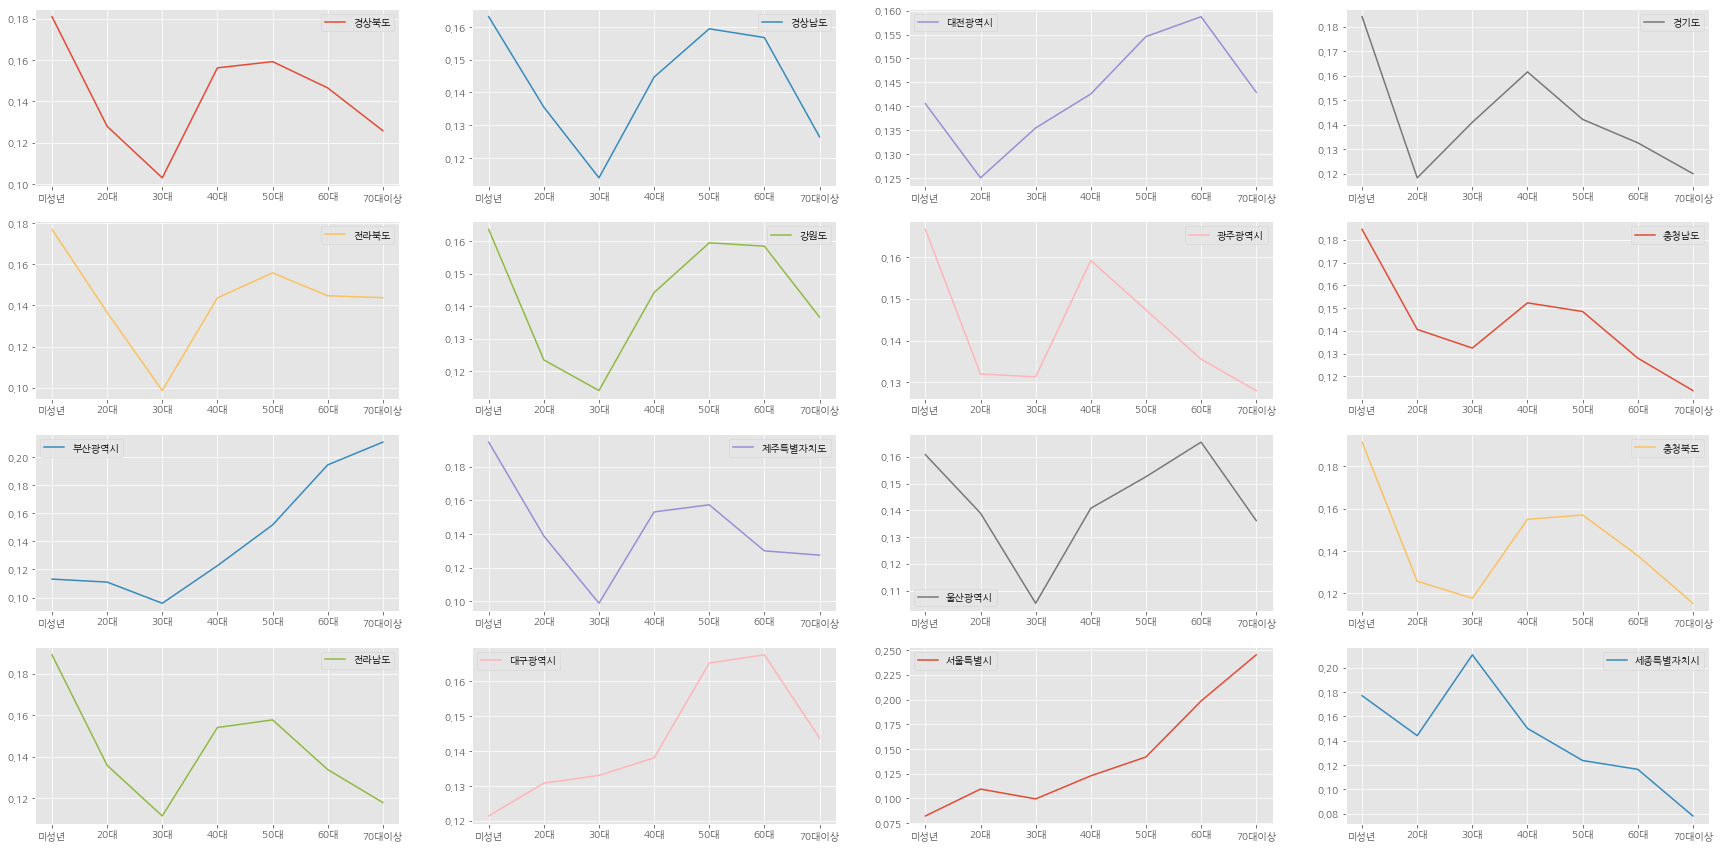

In [ ]:
age_info.T.plot(subplots = True, layout = (4, 4), figsize=(30,15), sharex=False)

In [ ]:
area_age_car = pd.read_csv('./data/area_age_car_info.csv', encoding='euc-kr')

In [ ]:
area_age_car.head()

,시점,행정구역별,합계,합계.1,15세 미만,15세 미만.1,15~19,15~19.1,20~24,20~24.1,...,55~59,55~59.1,60~64,60~64.1,65세이상,65세이상.1,65~69,65~69.1,70세이상,70세이상.1
0,시점,행정구역별,합계,합계,합계,합계,합계,합계,합계,합계,...,합계,합계,합계,합계,합계,합계,합계,합계,합계,합계
1,시점,행정구역별,일반가구 (가구),자동차 보유 가구-계 (가구),일반가구 (가구),자동차 보유 가구-계 (가구),일반가구 (가구),자동차 보유 가구-계 (가구),일반가구 (가구),자동차 보유 가구-계 (가구),...,일반가구 (가구),자동차 보유 가구-계 (가구),일반가구 (가구),자동차 보유 가구-계 (가구),일반가구 (가구),자동차 보유 가구-계 (가구),일반가구 (가구),자동차 보유 가구-계 (가구),일반가구 (가구),자동차 보유 가구-계 (가구)
2,2005,서울특별시,3309963,1799809,156,0,10618,279,102873,6683,...,305940,187154,242013,126740,385605,118713,178145,71628,207460,47085
3,2005,부산광역시,1186522,642709,165,0,4514,98,22921,2519,...,128472,71626,101090,45460,175751,40646,79962,25241,95789,15405
4,2005,대구광역시,814616,536919,97,0,3623,55,19688,2810,...,73423,51346,56525,32493,106801,31147,47422,19176,59379,11971


In [ ]:
area_age_car = area_age_car.drop(index=[0], axis = 0)
area_age_car = area_age_car.drop(columns=['시점'], axis=True)

In [ ]:
area_age_car['지역'] = area_age_car['행정구역별']
area_age_car = area_age_car.drop(columns=['행정구역별'], axis=True)
area_age_car = area_age_car.set_index(['지역'])

In [ ]:
area_age_car = area_age_car.drop(index=['행정구역별'], axis=0)

In [ ]:
area_age_car['미성년자_일반가구'] = area_age_car['15세 미만'] + area_age_car['15~19']
area_age_car['미성년자_차보유'] = area_age_car['15세 미만.1']	+ area_age_car['15~19.1']
area_age_car['20대_일반가구'] = area_age_car['20~24'] + area_age_car['25~29']
area_age_car['20대_차보유'] = area_age_car['20~24.1']	+ area_age_car['25~29.1']
area_age_car['30대_일반가구'] = area_age_car['30~34'] + area_age_car['35~39']
area_age_car['30대_차보유'] = area_age_car['30~34.1']	+ area_age_car['35~39.1']
area_age_car['40대_일반가구'] = area_age_car['40~44'] + area_age_car['45~49']
area_age_car['40대_차보유'] = area_age_car['40~44.1']	+ area_age_car['45~49.1']
area_age_car['50대_일반가구'] = area_age_car['50~54'] + area_age_car['55~59']
area_age_car['50대_차보유'] = area_age_car['50~54.1']	+ area_age_car['55~59.1']
area_age_car['60대_일반가구'] = area_age_car['60~64'] + area_age_car['65~69']
area_age_car['60대_차보유'] = area_age_car['60~64.1']	+ area_age_car['65~69.1']
area_age_car['70대이상_일반가구'] = area_age_car['70세이상']
area_age_car['70대이상_차보유'] = area_age_car['70세이상.1']

In [ ]:
area_age_car.head()

,합계,합계.1,15세 미만,15세 미만.1,15~19,15~19.1,20~24,20~24.1,25~29,25~29.1,...,30대_일반가구,30대_차보유,40대_일반가구,40대_차보유,50대_일반가구,50대_차보유,60대_일반가구,60대_차보유,70대이상_일반가구,70대이상_차보유
지역,,,,,,,,,,,,,,,,,,,,,
서울특별시,3309963,1799809,156,0,10618,279,102873,6683,241046,66405,...,374707402478,213433269448,426212454053,283424294057,364262305940,233473187154,242013178145,12674071628,207460,47085
부산광역시,1186522,642709,165,0,4514,98,22921,2519,45139,18340,...,89233123776,5881087679,156942182093,106858115036,156426128472,9563771626,10109079962,4546025241,95789,15405
대구광역시,814616,536919,97,0,3623,55,19688,2810,39931,21626,...,77158104682,6061684455,119220121673,9332691298,9179573423,6774751346,5652547422,3249319176,59379,11971
인천광역시,823100,527661,132,0,2395,111,17051,3115,46239,23617,...,90653113870,6646786630,137869130991,10382994430,8506763302,6007640990,4674337673,2504214132,51115,9222
광주광역시,460096,298197,63,0,3170,75,16991,2328,28364,14428,...,4874761412,3851651277,6613763958,5348149269,4414838117,3218625775,2948424057,157859062,35448,6015


In [ ]:
area_age_car = area_age_car.astype('float64')

In [ ]:
area_age_car_ratio = pd.DataFrame()
area_age_car_ratio['미성년자_차보유_비율'] = area_age_car['미성년자_차보유'] / area_age_car['미성년자_일반가구']
area_age_car_ratio['20대_차보유_비율'] = area_age_car['20대_차보유'] / area_age_car['20대_일반가구']
area_age_car_ratio['30대_차보유_비율'] = area_age_car['30대_차보유'] / area_age_car['30대_일반가구']
area_age_car_ratio['40대_차보유_비율'] = area_age_car['40대_차보유'] / area_age_car['40대_일반가구']
area_age_car_ratio['50대_차보유_비율'] = area_age_car['50대_차보유'] / area_age_car['50대_일반가구']
area_age_car_ratio['60대_차보유_비율'] = area_age_car['60대_차보유'] / area_age_car['60대_일반가구']
area_age_car_ratio['70대이상_차보유_비율'] = area_age_car['70대이상_차보유'] / area_age_car['70대이상_일반가구']

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

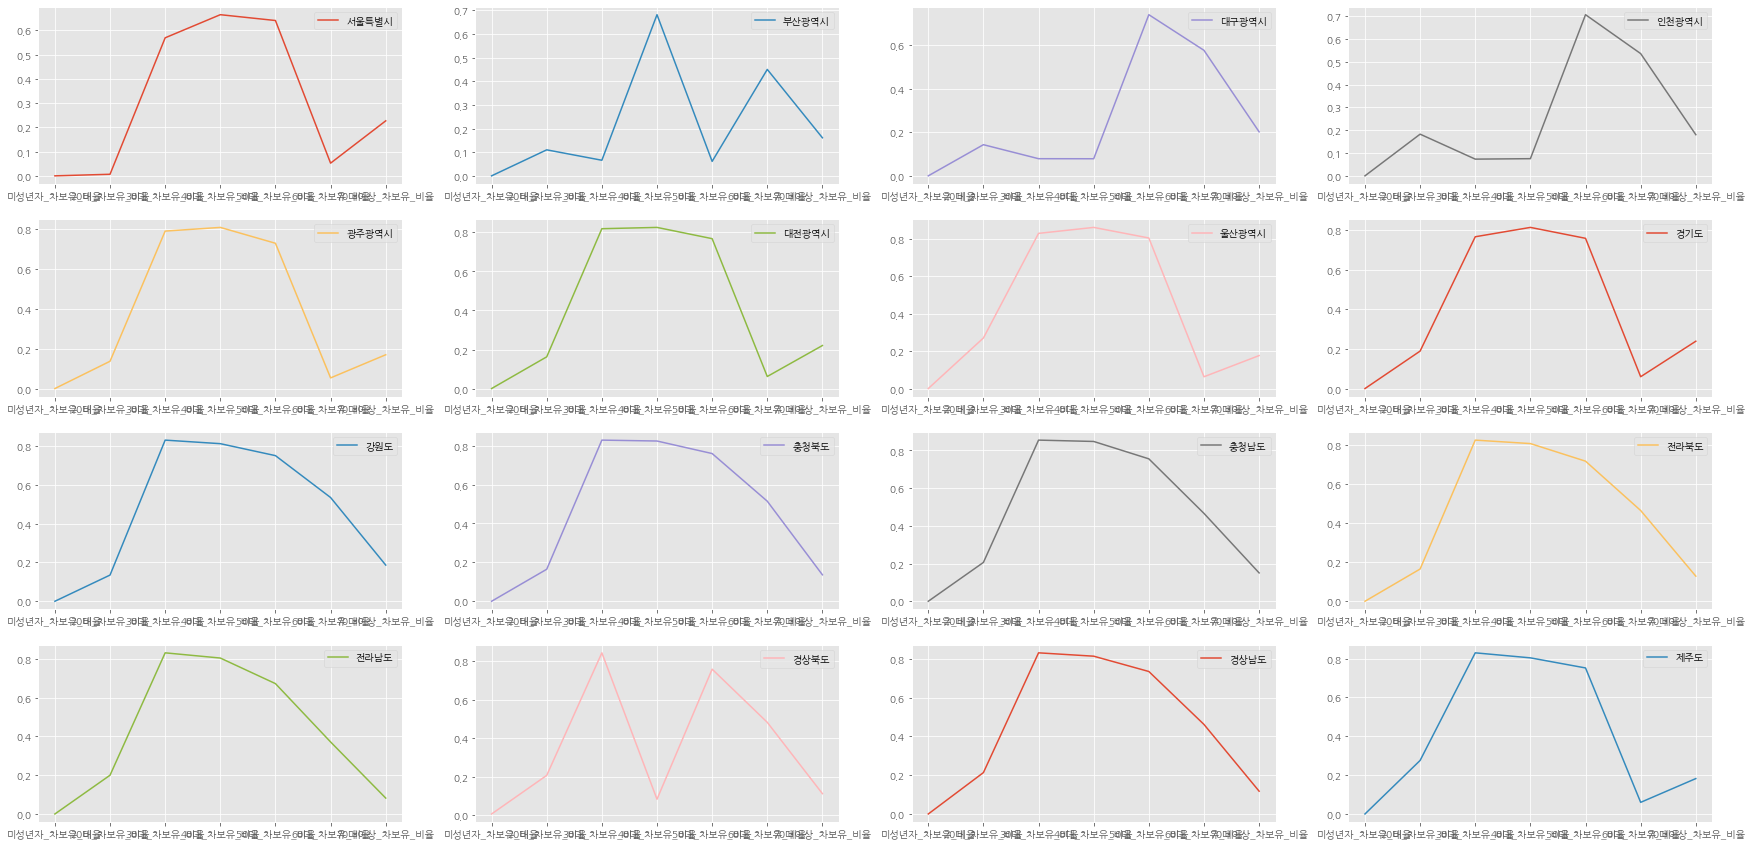

In [ ]:
area_age_car_ratio.T.plot(subplots = True, layout = (4, 4), figsize=(30,15), sharex=False)

In [ ]:
# 세종특별자치시의 자동차 보유 비율을 서울시로 대입
area_age_car_ratio.loc['세종특별자치시'] = area_age_car_ratio.loc['서울특별시']

In [ ]:
age_info.head()

,미성년,20대,30대,40대,50대,60대,70대이상
지역,,,,,,,
경상북도,0.181059,0.127956,0.103005,0.156273,0.159295,0.146573,0.125840
경상남도,0.163127,0.135538,0.113964,0.144691,0.159442,0.156763,0.126474
대전광역시,0.140571,0.125081,0.135501,0.142592,0.154570,0.158728,0.142957
경기도,0.184072,0.118378,0.141036,0.161562,0.142203,0.132656,0.120093
전라북도,0.176920,0.136585,0.098623,0.143650,0.155790,0.144678,0.143755


In [ ]:
set(area_age_car_ratio.index) - set(age_info.index)

{'인천광역시', '제주도'}

In [ ]:
area_age_car_ratio.rename(index={'제주도' : '제주특별자치도'}, inplace=True)

In [ ]:
area_age_car_ratio = area_age_car_ratio.drop(index=['인천광역시'], axis = 0)

In [ ]:
prob_area_car = pd.DataFrame()
for area in area_age_car_ratio.index:
    prob_area_car.loc[area, '자동차_보유확률'] = np.dot(area_age_car_ratio.loc[area], age_info.loc[area])

In [ ]:
prob_area_car.head()

,자동차_보유확률
서울특별시,0.296181
부산광역시,0.232783
대구광역시,0.287280
광주광역시,0.386988
대전광역시,0.409132


In [ ]:
prob_area_car = prob_area_car.reset_index()
prob_area_car.rename(columns={'index' : '지역'}, inplace=True)

In [ ]:
prob_area_car.head()

,지역,자동차_보유확률
0,서울특별시,0.296181
1,부산광역시,0.232783
2,대구광역시,0.287280
3,광주광역시,0.386988
4,대전광역시,0.409132


In [ ]:
df1 = train_eda[['단지코드', '지역', '실세대수', '등록차량수']].drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

In [ ]:
df1.head()

,단지코드,지역,실세대수,등록차량수
0,C2515,경상남도,528.0,205.0
7,C1407,대전광역시,1203.0,1064.0
18,C1945,경기도,749.0,730.0
24,C1470,전라북도,682.0,553.0
28,C1898,전라북도,557.0,415.0


In [ ]:
df1 = pd.merge(df1, prob_area_car, how='inner')

In [ ]:
df1.head()

,단지코드,지역,실세대수,등록차량수,자동차_보유확률
0,C2515,경상남도,528.0,205.0,0.44583
1,C2576,경상남도,386.0,73.0,0.44583
2,C2013,경상남도,591.0,91.0,0.44583
3,C1850,경상남도,385.0,254.0,0.44583
4,C1077,경상남도,840.0,236.0,0.44583


In [ ]:
df1['지역_예상보유수'] = df1['실세대수'] * df1['자동차_보유확률']

In [ ]:
# 단지를 리스트에 담기
apt_complex = df1['단지코드'].tolist()
# 세대수 / 대중교통 값 담기
pred_car_num = df1['지역_예상보유수'].tolist()

In [ ]:
train_eda = train_eda.set_index(['단지코드'])
for complex_, car_num in zip(apt_complex, pred_car_num):
    train_eda.loc[complex_, '지역_예상보유수'] = car_num
train_eda  = train_eda.reset_index()

## 8. 전용면적

In [ ]:
# 전용면적을 5의 배수로 구분
train_eda['전용면적'] = train_eda['전용면적']//5*5

In [ ]:
idx = train_eda[train_eda['전용면적'] > 100].index
train_eda.loc[idx, '전용면적'] = 100

idx = train_eda[train_eda['전용면적'] < 15].index
train_eda.loc[idx, '전용면적'] = 15

# 4. 최종 Train

In [ ]:
area_columns = []
for area in train_eda['전용면적'].unique():
    area_columns.append(f'면적_{area}')

new_train = pd.DataFrame()
new_test = pd.DataFrame()

for i, code in enumerate(train_eda['단지코드'].unique()):
    temp = train_eda[train_eda['단지코드']==code]
    temp.index = range(temp.shape[0])

    new_train.loc[i, '단지코드'] = temp.loc[0, '단지코드']
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_train.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()

In [ ]:
train_eda.to_csv('final_train_eda.csv', index=False)

In [ ]:
train_df = train_eda.copy()

In [ ]:
train_df = train_df[['단지코드','실세대수','임대건물구분','예상등록수','세대수/대중교통','단지평균_면적당_임대보증금','단지평균_면적당_임대료','지역_예상보유수','등록차량수']].drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

In [ ]:
new_train.head()

,단지코드,면적_30.0,면적_35.0,면적_45.0,면적_50.0,면적_40.0,면적_55.0,면적_25.0,면적_20.0,면적_70.0,면적_80.0,면적_15.0,면적_100.0,면적_60.0,면적_75.0
0,C2515,276.0,80.0,57.0,132.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C1407,390.0,0.0,340.0,124.0,362.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C1945,0.0,240.0,0.0,303.0,0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C1470,0.0,254.0,196.0,246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,C1898,0.0,271.0,209.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_df = pd.merge(train_df, new_train, on='단지코드', how='right')

In [ ]:
train_df.to_csv('final_train_df.csv', index=False)

# 5. Test 전처리

In [ ]:
def data_eda(df):
    # 실세대수 변수 생성
    df['실세대수'] = df['총세대수'] - df['공가수']
    
    # 임대건물구분
    # 같은 단지내에 임대건물 구분이 2가지인 경우
    apt_shop_list = []
    apt_only_list = []
    for complex_ in df['단지코드'].unique().tolist():
        if len(df[df['단지코드'] == complex_]['임대건물구분'].unique()) != 1:
            apt_shop_list.append(complex_)
        else:
            apt_only_list.append(complex_)
    
    df = df.set_index(['단지코드'])
    # 임대건물구분이 아파트만 있는 경우 0
    df.loc[apt_only_list,'임대건물구분'] = 0
    # 임대건물구분이 아파트와 상가로 되어있는 경우 1
    df.loc[apt_shop_list,'임대건물구분'] = 1
    df = df.reset_index()
    df['임대건물구분'] = df['임대건물구분'].astype('int')
    
    
    # 주차규정
    # 구차규정에 따른 지역을 구분
    special_city = ['서울특별시']
    metropolitan_city = ['세종특별자치시', '광주광역시', '부산광역시', '울산광역시', '대전광역시', '대구광역시']
    else_city = ['경상남도', '경기도', '전라북도', '강원도', '충청남도', '제주특별자치도', '충청북도', '전라남도', '경상북도']
    
    df[['주차장_설치기준']] = df.apply(lambda x: parking_rule(x), axis = 1)
    df['전용면적별_주차기준_예상등록수'] = df['전용면적별세대수'] * df['주차장_설치기준']
    pred_by_rule = df.groupby(['단지코드'])['전용면적별_주차기준_예상등록수'].sum()
    
    df = df.set_index(['단지코드'])
    for complex_ in pred_by_rule.index:
        df.loc[complex_,'예상등록수'] = pred_by_rule[complex_]
    df = df.reset_index(['단지코드'])
    
    
    # 임대보증금과 임대료 결측치 제거
    df['임대보증금'] = df['임대보증금'].fillna(0)
    df['임대료'] = df['임대료'].fillna(0)
    df['임대보증금'] = df['임대보증금'].astype('float64')
    df['임대료'] = df['임대료'].astype('float64')
    
    # 임대보증금 / 전용면적, 임대료 / 전용면적 을 통한 면적당 임대보증금과 임대료 산출
    df['면적당_임대보증금'] = df['임대보증금'] / df['전용면적']
    df['면적당_임대료'] = df['임대료'] / df['전용면적']
    
    # 단지별 대표 임대보증금과 임대료 가중치 평균을 통해 산출
    df = df.set_index(['단지코드'])

    for complex_ in df.index.unique():
        # 단지별 면적당 임대보증금 평균값
        avg_rental_deposit = np.dot(df.loc[complex_]['면적당_임대보증금'], df.loc[complex_]['전용면적별세대수']) / df.loc[complex_]['총세대수']
        # 단지별 면적당 임대료 평균값
        avg_rental_cost = np.dot(df.loc[complex_]['면적당_임대료'], df.loc[complex_]['전용면적별세대수']) / df.loc[complex_]['총세대수']
        df.loc[complex_, '단지평균_면적당_임대보증금'] = avg_rental_deposit
        df.loc[complex_, '단지평균_면적당_임대료'] = avg_rental_cost

    df = df.reset_index()
    
    # 대중교통
    df['지하철'] = df['도보 10분거리 내 지하철역 수(환승노선 수 반영)']
    df.drop(columns = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)'], axis = 1, inplace = True)
    df['버스'] = df['도보 10분거리 내 버스정류장 수']
    df.drop(columns = ['도보 10분거리 내 버스정류장 수'], axis = 1, inplace = True)
    
    df['지하철'] = df['지하철'].fillna(0)
    df['대중교통'] = df['지하철'] + df['버스']
    
    df1 = df[['단지코드', '실세대수', '대중교통']].drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
    df1['세대수/대중교통'] = np.log(df1['실세대수'] / (df1['대중교통'] + 0.0000001))
    
    # 단지를 리스트에 담기
    apt_complex = df1['단지코드'].tolist()
    # 세대수 / 대중교통 값 담기
    public_transform_ratio = df1['세대수/대중교통'].tolist()
    
    df = df.set_index(['단지코드'])
    for complex_, ratio_ in zip(apt_complex, public_transform_ratio):
        df.loc[complex_, '세대수/대중교통'] = ratio_
    df  = df.reset_index()
    
    
    # 단지 합치기
    df1 = df[['단지코드', '지역', '실세대수']].drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
    df1 = pd.merge(df1, prob_area_car, how='inner')
    df1['지역_예상보유수'] = df1['실세대수'] * df1['자동차_보유확률']
    # 단지를 리스트에 담기
    apt_complex = df1['단지코드'].tolist()
    # 세대수 / 대중교통 값 담기
    pred_car_num = df1['지역_예상보유수'].tolist()
    
    df = df.set_index(['단지코드'])
    for complex_, car_num in zip(apt_complex, pred_car_num):
        df.loc[complex_, '지역_예상보유수'] = car_num
    df  = df.reset_index()
    
    df['전용면적'] = df['전용면적']//5*5
    idx = df[df['전용면적'] > 100].index
    df.loc[idx, '전용면적'] = 100

    idx = df[df['전용면적'] < 15].index
    df.loc[idx, '전용면적'] = 15
    
    area_columns = ['면적_30.0','면적_35.0','면적_45.0','면적_50.0','면적_40.0','면적_55.0','면적_25.0','면적_20.0','면적_70.0','면적_80.0','면적_15.0','면적_100.0','면적_60.0','면적_75.0']

    new_train = pd.DataFrame()

    for i, code in tqdm(enumerate(df['단지코드'].unique())):
        temp = df[df['단지코드']==code]
        temp.index = range(temp.shape[0])

        new_train.loc[i, '단지코드'] = temp.loc[0, '단지코드']

        for col in area_columns:
            area = float(col.split('_')[-1])
            new_train.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()
            
    df = df[['단지코드','실세대수','임대건물구분','예상등록수','세대수/대중교통','단지평균_면적당_임대보증금','단지평균_면적당_임대료','지역_예상보유수']].drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
    df = pd.merge(df, new_train, on='단지코드', how='right')

    return df

In [ ]:
data_eda(test).to_csv('final_test.csv', index=False)

150it [00:02, 70.33it/s]


# 6. 모델링

## 0. answer to submission

In [ ]:
def answer_to_submission(test, model, model_name, submission):
    test_df = data_eda(test)
    X_test = test_df.iloc[:, 1:]
    
    test_pred = model.predict(X_test)
    
    submission['num'] = test_pred
    
    now = time.localtime()
    submission.to_csv(f"{model_name}_{time.strftime('%m%d', now)}.csv", index=False)
    print(f"{model_name}_model_{time.strftime('%m%d', now)}.csv" + "생성완료")

## 1. RandomForestRegressor

In [ ]:
X = train_df.drop(['단지코드', '등록차량수'], axis = 1)
y = train_df['등록차량수']

In [ ]:
X_train, X_validation , y_train, y_validation = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
model_rf = RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
model_rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
train_rf_pred = model_rf.predict(X_validation)

In [ ]:
mean_absolute_error(y_validation, train_rf_pred)

164.8272440944882

In [ ]:
answer_to_submission(test, model_rf, 'RandomForestRegressor', submission)

150it [00:02, 66.40it/s]


RandomForestRegressor_model_0922.csv생성완료


## 2. XGBRegressor

In [ ]:
#XGBRegressor: XGboost 알고리즘을 이용하여 값을 예측하는 객체
model_xgb = XGBRegressor(n_estimators = 150, # 150개의 의사 결정 트리를 이용하여 값을 예측
                         max_depth = 5, 
                         random_state = 0,
                         min_child_weight=7,
                         learning_rate = 0.1)

In [ ]:
#X_train을 독립변수로 y_train을 예측하는 XGBoost 객체를 실행
model_xgb.fit(X_train, y_train)

[21:44:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=5, min_child_weight=7, n_estimators=150)

In [ ]:
train_xgb_pred = model_xgb.predict(X_validation)

In [ ]:
mean_absolute_error(y_validation, train_xgb_pred)

154.75124947855792

In [ ]:
answer_to_submission(test, model_xgb, 'XGBRegressor', submission)

150it [00:02, 68.16it/s]

XGBRegressor_model_0922.csv생성완료


## 3. CatBoostRegressor

In [ ]:
test_df = data_eda(test)
test_df = test_df.iloc[:, 1:]

150it [00:02, 66.17it/s]


In [ ]:
# K Fold 및 기본 데이터 준비 
folds = KFold(n_splits = 7, shuffle = True, random_state = 511)
oof_preds_catboost = np.zeros(train_df.shape[0])
# catboost 이용 
print("using catboost") 
sub_preds_catboost = np.zeros(test_df.shape[0]) 
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_df)) :
    trn_x, trn_y = X.iloc[trn_idx], y.iloc[trn_idx] 
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx] 
    model_catboost = CatBoostRegressor(loss_function='MAE')
    
    model_catboost.fit(trn_x, trn_y, 
                 eval_set=(val_x, val_y),
                 use_best_model=True, 
                 verbose=False,
                 early_stopping_rounds=100,
                 plot=True) 
    oof_preds_catboost[val_idx] = model_catboost.predict(val_x) 
    sub_preds_catboost += model_catboost.predict(test_df) / folds.n_splits


using catboost


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
model_catboost.get_best_score()

{'learn': {'MAE': 82.31632408299112}, 'validation': {'MAE': 97.44119750448797}}

In [ ]:
submission['num'] = sub_preds_catboost

now = time.localtime()
submission.to_csv(f"catboost_best_model_{time.strftime('%m%d', now)}.csv", index=False)
print(f"catboost_best_model_{time.strftime('%m%d', now)}.csv" + "생성완료")

catboost_best_model_0922.csv생성완료


In [ ]:
sorted_feature_importance = model_catboost.feature_importances_.argsort()

In [ ]:
sorted_feature_importance

array([20, 19, 15, 16,  7, 14, 17, 11,  3, 18,  8, 12, 10, 13,  5,  4,  6,
        1,  9,  0,  2], dtype=int64)

Text(0.5, 0, 'CatBoost Feature Importance')

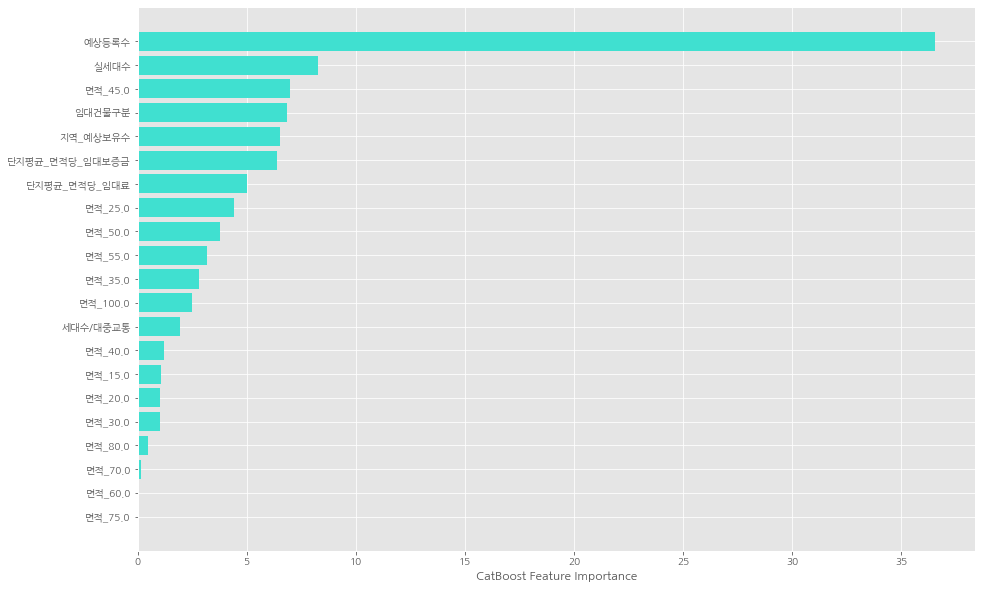

In [ ]:
plt.figure(figsize=(15,10))
plt.barh(X.columns[sorted_feature_importance], 
        model_catboost.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")